# Importing Dataset

In [2]:
import os
import yaml
import torch.multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
# wandb config
import wandb
from dotenv import load_dotenv
load_dotenv()
from wandb.integration.ultralytics import add_wandb_callback
from ultralytics import YOLO
from collections import Counter

# Initialize your Weights & Biases environment
!yolo settings wandb=True



cwd = os.getcwd()
dataset_root_folder = os.path.join(cwd, "../../dataset")

# Funzione per generare i grafici delle perdite (Train e Validation Losses)
def plot_losses(data, figsize=(12, 10), title="Train and Validation Losses Over Epochs"):
    """
    Funzione per creare un plot delle perdite (Losses) di training e validazione su una griglia 2x2.

    Args:
        data (DataFrame): Un DataFrame contenente i dati da plottare.
        figsize (tuple): Dimensione della figura (larghezza, altezza).
        title (str): Titolo principale della figura.
    """
    # Configurazione dei grafici (fissa)
    plots = [
        (0, 0, 'Loss', 'blue', 'orange', 'Box Loss', 'train/box_loss', 'val/box_loss'),
        (0, 1, 'Loss', 'green', 'red', 'Class Loss', 'train/cls_loss', 'val/cls_loss'),
        (1, 0, 'Loss', 'purple', 'cyan', 'DFL Loss', 'train/dfl_loss', 'val/dfl_loss'),
        (1, 1, 'Score', 'magenta', 'brown', 'Validation Metrics', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)')
    ]

    # Configura la figura
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16)

    # Creazione dei grafici iterativamente
    for r, c, ylabel, color_train, color_val, plot_title, key_train, key_val in plots:
        ax = axes[r, c]
        ax.plot(data['epoch'], data[key_train], label=f'Train {plot_title}', color=color_train)
        ax.plot(data['epoch'], data[key_val], label=f'Val {plot_title}', color=color_val)
        ax.set_title(plot_title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid()

    # Layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_dataset(dataset_root):
    """
    Analyzes a YOLO dataset and plots the image distribution per split (train, valid, test)
    and the class distribution.

    Args:
        dataset_root (str): Path to the root of the YOLO dataset (should include 'train', 'valid', and 'test').
    """
    # Path to the YAML file
    yaml_path = os.path.join(dataset_root, "data.yaml")

    # Check if YAML file exists
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"'data.yaml' file not found in {dataset_root}")

    # Read class names from the YAML file
    with open(yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)
        class_names = data_config['names']

    # Subdirectories for train, valid, and test
    splits = ['train', 'valid', 'test']

    # Image distribution and class counts
    image_distribution = {}
    class_counts = Counter()

    for split in splits:
        images_dir = os.path.join(dataset_root, split, "images")
        labels_dir = os.path.join(dataset_root, split, "labels")

        # Count images
        if os.path.exists(images_dir):
            num_images = len([f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))])
            image_distribution[split] = num_images

        # Count classes
        if os.path.exists(labels_dir):
            for label_file in os.listdir(labels_dir):
                label_path = os.path.join(labels_dir, label_file)
                try:
                    with open(label_path, 'r') as file:
                        for line in file:
                            class_id = line.split()[0]
                            class_counts[class_id] += 1
                except PermissionError:
                    print(f"Permission denied for file: {label_path}")
                except Exception as e:
                    print(f"Error with file {label_path}: {e}")

    # Plot image distribution
    plt.figure(figsize=(10, 5))
    plt.bar(image_distribution.keys(), image_distribution.values(), color='skyblue')
    plt.title("Image Distribution per Split")
    plt.xlabel("Split")
    plt.ylabel("Number of Images")
    plt.show()

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    class_ids = [int(cid) for cid in class_counts.keys()]
    frequencies = [class_counts[cid] for cid in class_counts.keys()]
    class_labels = [class_names[cid] for cid in class_ids]

    plt.bar(class_labels, frequencies, color='salmon')
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(matrix_path):
    matrix = plt.imread(matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix)
    plt.axis('off')
    plt.show()

C:\Users\siani\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


JSONDict("C:\Users\siani\AppData\Roaming\Ultralytics\settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "C:\\Users\\siani\\PycharmProjects\\AIxFootballAnalysis\\src\\training\\datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "4164f6bf860d8010f015d455e8afd5ad6b00d6918e89b195fad8e40aabf4e174",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


 # Determining best YOLO version

We'll evaluate three distinct version:

1. YOLO8L 
2. YOLO9c 
3. YOLO5L

**Dataset**

For this experiment we'll employ dataset's version 0. 
Such version is made of the **645** raw images, half of them taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 , while the other half was manually annotated

(such dataset is available at https://app.roboflow.com/emasengineeringworkspace/aixfootballanalysis/6)

Train val test split:
* Train = 510 images
* Val = 75 images
* Test = 60 images

## YOLO v8L

In [2]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8l.pt")
model = model.cuda()
# print current path
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v0")

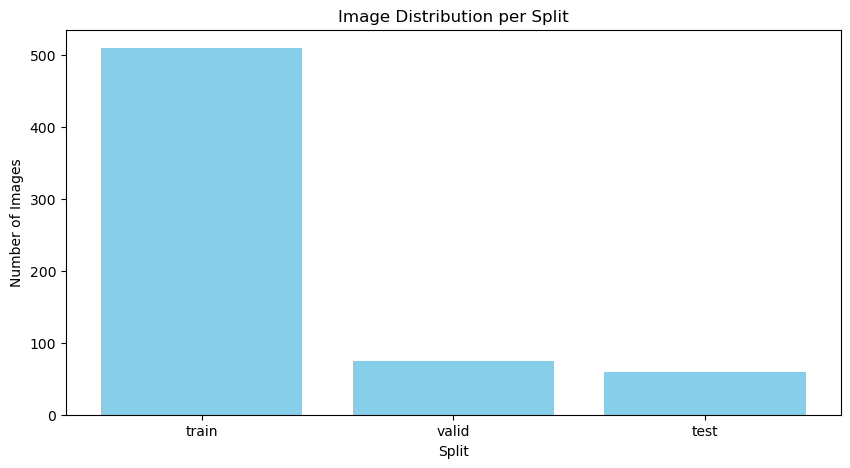

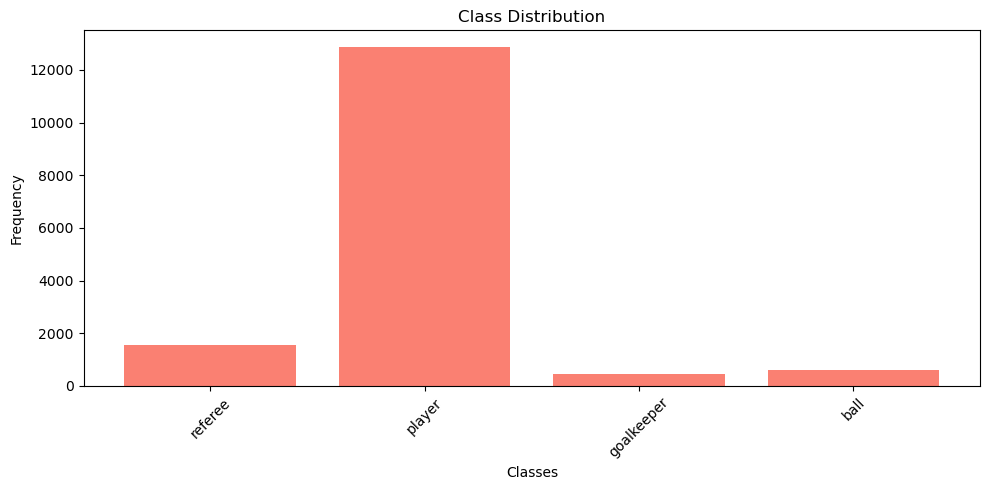

In [3]:
# plot dataset
plot_dataset(dataset_path)

In [ ]:
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolo_football_analysis", name="yolo8L_dataset_v0")

New https://pypi.org/project/ultralytics/8.3.78 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v0\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolo_football_analysis, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

wandb: Currently logged in as: sianiemanuele (sianiemanuele_07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\train\labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\train\labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to yolo_football_analysis\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_football_analysis\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.4G      1.379      1.838     0.8405        613        640: 100%|██████████| 32/32 [08:31<00:00, 15.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


                   all         75       1796      0.245      0.308      0.209      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.1G      1.339     0.9143     0.8262        720        640: 100%|██████████| 32/32 [09:32<00:00, 17.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]


                   all         75       1796      0.245      0.308      0.209      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.3G       1.38     0.8181       0.83        532        640: 100%|██████████| 32/32 [08:29<00:00, 15.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.90s/it]


                   all         75       1796      0.238       0.02     0.0202     0.0123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.2G      1.325     0.7318     0.8214        550        640: 100%|██████████| 32/32 [08:04<00:00, 15.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.85s/it]


                   all         75       1796      0.371      0.349      0.149     0.0727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.1G      1.262     0.6651     0.8171        511        640: 100%|██████████| 32/32 [08:02<00:00, 15.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.51s/it]


                   all         75       1796      0.801      0.578      0.613      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.2G      1.245     0.6275     0.8153        520        640: 100%|██████████| 32/32 [08:33<00:00, 16.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.89s/it]


                   all         75       1796      0.716       0.59      0.622      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.2G      1.281     0.6346     0.8197        586        640: 100%|██████████| 32/32 [07:48<00:00, 14.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


                   all         75       1796      0.798      0.589      0.646      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.2G      1.327     0.6804     0.8189        459        640: 100%|██████████| 32/32 [07:37<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.43s/it]


                   all         75       1796      0.877      0.607      0.678      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.2G      1.203     0.6086      0.812        543        640: 100%|██████████| 32/32 [08:04<00:00, 15.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


                   all         75       1796      0.846      0.641      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.2G      1.161     0.5833     0.8088        652        640: 100%|██████████| 32/32 [08:39<00:00, 16.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.32s/it]


                   all         75       1796       0.86      0.626      0.693      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.1G      1.134     0.5562     0.8071        671        640: 100%|██████████| 32/32 [09:02<00:00, 16.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


                   all         75       1796       0.86      0.649      0.701      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.2G      1.154     0.5703     0.8086        689        640: 100%|██████████| 32/32 [08:43<00:00, 16.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


                   all         75       1796      0.844      0.629      0.692      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.1G      1.147     0.5637      0.806        548        640: 100%|██████████| 32/32 [08:59<00:00, 16.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]


                   all         75       1796      0.867      0.688      0.742      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.2G        1.1     0.5357     0.8025        552        640: 100%|██████████| 32/32 [08:20<00:00, 15.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.58s/it]


                   all         75       1796       0.94      0.674      0.734      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.1G      1.139     0.5435     0.8034        471        640: 100%|██████████| 32/32 [08:08<00:00, 15.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


                   all         75       1796      0.869      0.671      0.729      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.2G      1.101     0.5306     0.8039        702        640: 100%|██████████| 32/32 [09:09<00:00, 17.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


                   all         75       1796      0.813      0.713      0.748       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.2G      1.072     0.5149     0.8001        490        640: 100%|██████████| 32/32 [08:14<00:00, 15.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


                   all         75       1796      0.839        0.7      0.748      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.2G      1.057     0.5011     0.8004        751        640: 100%|██████████| 32/32 [08:10<00:00, 15.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


                   all         75       1796      0.811      0.694      0.729       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.1G      1.061     0.5061     0.7986        578        640: 100%|██████████| 32/32 [08:20<00:00, 15.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]


                   all         75       1796       0.79      0.658      0.706      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.1G      1.044     0.4993     0.7974        580        640: 100%|██████████| 32/32 [07:34<00:00, 14.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.29s/it]


                   all         75       1796      0.913      0.678      0.757      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.1G      1.053     0.4958     0.7982        690        640: 100%|██████████| 32/32 [07:36<00:00, 14.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


                   all         75       1796      0.865      0.717      0.756      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.2G      1.105     0.5213     0.7995        610        640: 100%|██████████| 32/32 [07:28<00:00, 14.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


                   all         75       1796      0.889      0.699      0.758      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.3G      1.017     0.4838     0.7956        465        640: 100%|██████████| 32/32 [07:45<00:00, 14.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.38s/it]


                   all         75       1796      0.862      0.724      0.778      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.2G      1.021     0.4796     0.7942        694        640: 100%|██████████| 32/32 [07:31<00:00, 14.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.54s/it]


                   all         75       1796      0.904      0.686      0.747      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.1G     0.9932     0.4695     0.7971        530        640: 100%|██████████| 32/32 [07:53<00:00, 14.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


                   all         75       1796      0.862      0.714      0.758      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.1G      1.015     0.4721     0.7959        447        640: 100%|██████████| 32/32 [08:03<00:00, 15.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


                   all         75       1796      0.952      0.708      0.767      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.3G     0.9856     0.4616     0.7948        503        640: 100%|██████████| 32/32 [07:44<00:00, 14.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


                   all         75       1796      0.928      0.722      0.779      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.2G      0.994     0.4618     0.7944        527        640: 100%|██████████| 32/32 [06:57<00:00, 13.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.95s/it]


                   all         75       1796       0.92      0.715      0.782      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.2G     0.9788     0.4535     0.7934        520        640: 100%|██████████| 32/32 [08:07<00:00, 15.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.64s/it]


                   all         75       1796      0.878      0.744      0.788      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.1G     0.9899     0.4569     0.7941        494        640: 100%|██████████| 32/32 [07:43<00:00, 14.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


                   all         75       1796      0.873      0.701      0.764      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.2G     0.9881     0.4569     0.7952        545        640: 100%|██████████| 32/32 [08:32<00:00, 16.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


                   all         75       1796      0.857      0.745      0.788        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.2G     0.9602     0.4449     0.7914        681        640: 100%|██████████| 32/32 [07:38<00:00, 14.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


                   all         75       1796      0.877      0.718      0.767      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.2G     0.9774     0.4485     0.7921        539        640: 100%|██████████| 32/32 [06:14<00:00, 11.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.41s/it]


                   all         75       1796      0.938      0.704       0.79      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.2G     0.9761     0.4488     0.7909        589        640: 100%|██████████| 32/32 [06:10<00:00, 11.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.44s/it]


                   all         75       1796      0.911      0.729      0.779      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.2G      0.953      0.434     0.7899        490        640: 100%|██████████| 32/32 [07:19<00:00, 13.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


                   all         75       1796      0.866      0.733       0.79      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.2G     0.9474     0.4342     0.7919        587        640: 100%|██████████| 32/32 [07:14<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


                   all         75       1796      0.941       0.72      0.787      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.2G     0.9374     0.4281     0.7913        523        640: 100%|██████████| 32/32 [07:13<00:00, 13.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.51s/it]


                   all         75       1796      0.912      0.728      0.796      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.1G     0.9165     0.4197     0.7909        606        640: 100%|██████████| 32/32 [07:13<00:00, 13.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.67s/it]


                   all         75       1796      0.917      0.729      0.797      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.2G     0.9247     0.4188     0.7919        502        640: 100%|██████████| 32/32 [07:29<00:00, 14.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


                   all         75       1796      0.915      0.721      0.795      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.2G      0.944     0.4253     0.7904        640        640: 100%|██████████| 32/32 [06:53<00:00, 12.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


                   all         75       1796      0.902      0.724        0.8      0.532
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.1G      0.914     0.4193     0.7924        325        640: 100%|██████████| 32/32 [06:22<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


                   all         75       1796      0.866      0.742      0.801      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.1G     0.8732      0.409      0.789        313        640: 100%|██████████| 32/32 [07:12<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


                   all         75       1796      0.913      0.725      0.783      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.1G     0.8579      0.398     0.7926        329        640: 100%|██████████| 32/32 [07:59<00:00, 14.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


                   all         75       1796      0.841       0.71      0.768      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.2G     0.8688     0.4008     0.7911        318        640: 100%|██████████| 32/32 [06:41<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


                   all         75       1796      0.905      0.733      0.802      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        10G     0.8371     0.3869     0.7859        326        640: 100%|██████████| 32/32 [08:30<00:00, 15.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


                   all         75       1796      0.942      0.725      0.796      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.1G     0.8363      0.385     0.7904        327        640: 100%|██████████| 32/32 [07:49<00:00, 14.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


                   all         75       1796      0.921      0.743      0.803      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.2G     0.8365     0.3898     0.7865        332        640: 100%|██████████| 32/32 [07:53<00:00, 14.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


                   all         75       1796        0.9      0.737      0.789       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.1G     0.8323     0.3804     0.7857        332        640: 100%|██████████| 32/32 [07:35<00:00, 14.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


                   all         75       1796      0.899      0.743      0.799      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50        10G     0.8339     0.3811      0.789        320        640: 100%|██████████| 32/32 [07:03<00:00, 13.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


                   all         75       1796      0.891      0.735      0.803      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.1G      0.809     0.3697     0.7877        321        640: 100%|██████████| 32/32 [07:46<00:00, 14.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


                   all         75       1796      0.895       0.74      0.808      0.545

50 epochs completed in 6.793 hours.
Optimizer stripped from yolo_football_analysis\train\weights\last.pt, 87.6MB
Optimizer stripped from yolo_football_analysis\train\weights\best.pt, 87.6MB

Validating yolo_football_analysis\train\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


                   all         75       1796      0.895       0.74      0.808      0.544
                  ball         73         73      0.849      0.231      0.375      0.134
            goalkeeper         50         50      0.849       0.82      0.888      0.613
                player         75       1493       0.95       0.97       0.99       0.75
               referee         75        180       0.93      0.939       0.98      0.678
Speed: 0.8ms preprocess, 10.0ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to yolo_football_analysis\train


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
metrics/mAP50(B),▃▃▁▂▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
metrics/mAP50-95(B),▂▂▁▂▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██████████████
metrics/precision(B),▁▁▁▇▆▇▇▇▇▇█▇▇▇▇█▇▇▇████▇▇██▇████▇█▇██▇▇▇
metrics/recall(B),▄▁▄▆▆▇▇▇▇▇▇▇███▇███▇████████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇█▇▇▆▇▆▅▅▅▅▅▄▄▄▄▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000026AE607A920>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
wandb.finish()

Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


                   all         75       1796      0.883      0.738      0.802      0.552
                  ball         73         73      0.799      0.218      0.348      0.134
            goalkeeper         50         50      0.849       0.82      0.889      0.639
                player         75       1493       0.95      0.971       0.99      0.758
               referee         75        180      0.936      0.944      0.982      0.679
Speed: 1.0ms preprocess, 15.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to yolo_football_analysis\train2


### Plots

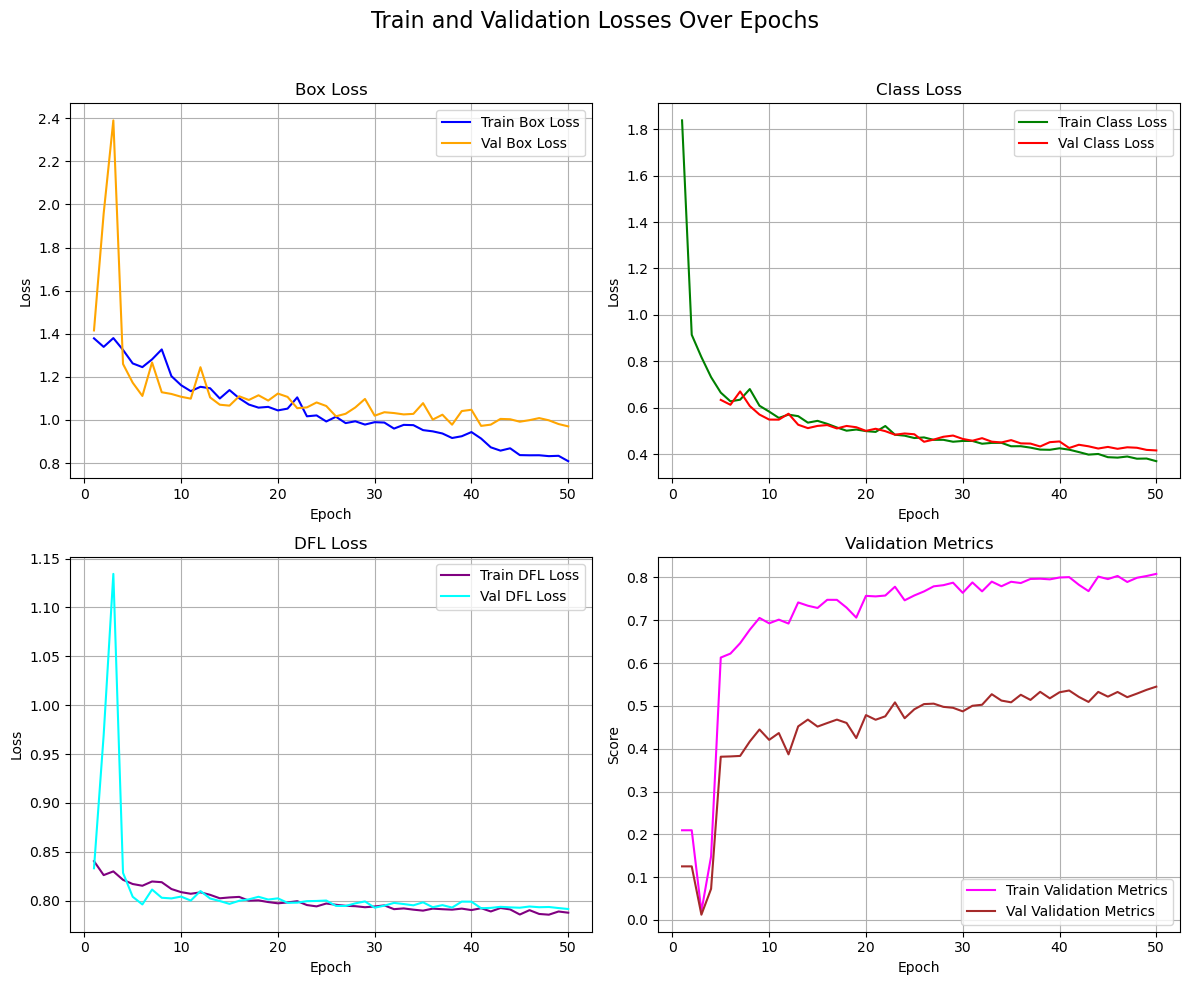

In [18]:
results_path = os.path.join(cwd, "yolo_football_analysis", "yolo8L_dataset_v0", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

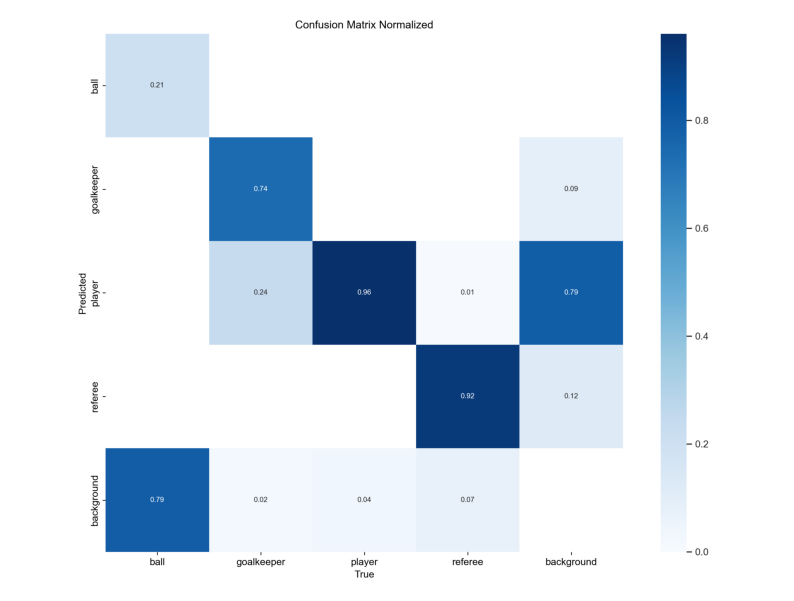

In [19]:
# load and show confusion matrix
matrix_path = os.path.join(cwd, "yolo_football_analysis", "yolo8L_dataset_v0", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)


## YOLO v5Lu

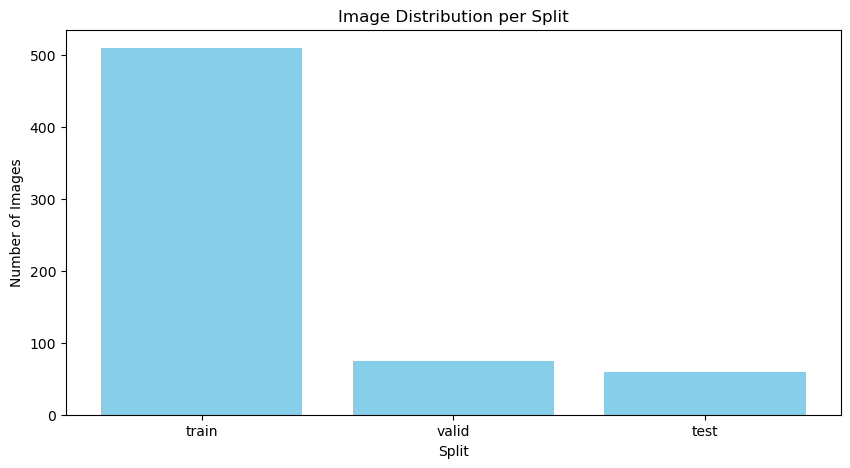

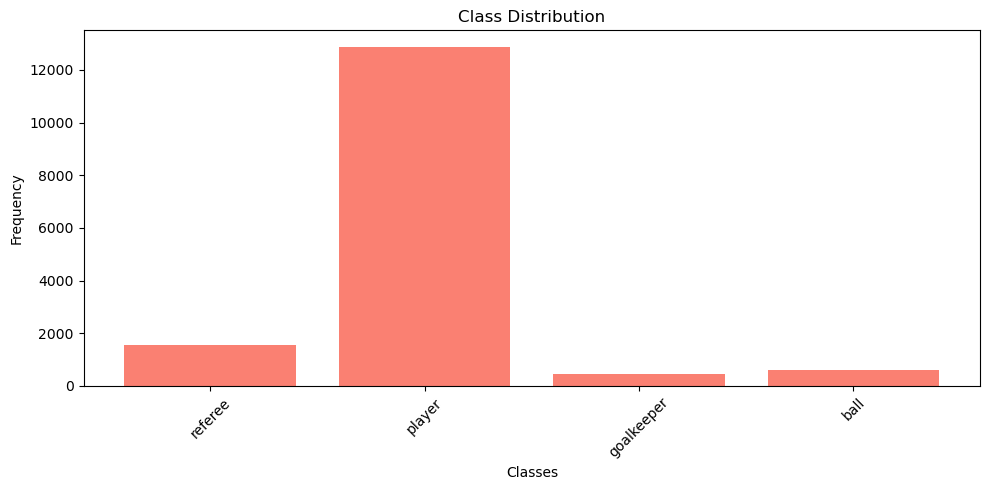

In [5]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov5lu.pt")
model = model.cuda()
# print current path
dataset_path = os.path.join(dataset_root_folder, "yolov5", "v0")
# plot dataset
plot_dataset(dataset_path)

In [6]:
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolo_football_analysis", name="yolo5L_dataset_v0")
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, save_dir="yolov5", project="yolo_football_analysis")
wandb.finish()

New https://pypi.org/project/ultralytics/8.3.78 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov5lu.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov5\v0\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolo_football_analysis, name=yolo5L_dataset_v0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

wandb: Currently logged in as: sianiemanuele (sianiemanuele_07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels...:   0%|          | 0/510 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels... 57 images, 0 backgrounds, 0 corrupt:  11%|█         | 57/510 [00:00<00:00, 566.28it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels... 130 images, 0 backgrounds, 0 corrupt:  25%|██▌       | 130/510 [00:00<00:00, 624.54it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels... 210 images, 0 backgrounds, 0 corrupt:  41%|████      | 210/510 [00:00<00:00, 686.08it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels... 279 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 279/510 [00:00<00:00, 681.22it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels... 351 images, 0 backgrounds, 0 corrupt:  

train: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\train\labels.cache


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels...:   0%|          | 0/75 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels... 33 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 33/75 [00:00<00:00, 325.17it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 428.79it/s]


val: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels.cache
Plotting labels to yolo_football_analysis\yolo5L_dataset_v0\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_football_analysis\yolo5L_dataset_v0
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        11G      1.337      1.649     0.8379        613        640: 100%|██████████| 32/32 [07:35<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


                   all         75       1796      0.494      0.305      0.259       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.6G      1.303     0.8391     0.8233        720        640: 100%|██████████| 32/32 [06:29<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


                   all         75       1796      0.773      0.544       0.59      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.6G       1.38     0.7907     0.8301        532        640: 100%|██████████| 32/32 [06:00<00:00, 11.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


                   all         75       1796      0.746      0.472      0.534      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.7G      1.319     0.6935      0.822        550        640: 100%|██████████| 32/32 [05:56<00:00, 11.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


                   all         75       1796       0.81       0.59       0.66      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.6G      1.257     0.6728       0.82        511        640: 100%|██████████| 32/32 [05:41<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


                   all         75       1796      0.786      0.616      0.679      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.7G      1.186     0.6327     0.8151        520        640: 100%|██████████| 32/32 [05:49<00:00, 10.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


                   all         75       1796      0.779      0.685      0.707      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.7G      1.165     0.5994      0.814        586        640: 100%|██████████| 32/32 [05:35<00:00, 10.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


                   all         75       1796      0.891      0.641      0.719      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.7G      1.154     0.5775     0.8087        459        640: 100%|██████████| 32/32 [05:42<00:00, 10.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]


                   all         75       1796      0.925      0.627      0.715      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.7G      1.214     0.6084     0.8131        543        640: 100%|██████████| 32/32 [05:12<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


                   all         75       1796        0.9        0.6      0.692      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.7G      1.153     0.5762      0.811        652        640: 100%|██████████| 32/32 [05:31<00:00, 10.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


                   all         75       1796      0.884      0.643      0.718      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.6G      1.087      0.556     0.8047        671        640: 100%|██████████| 32/32 [06:05<00:00, 11.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.16s/it]


                   all         75       1796       0.73      0.568      0.597      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.7G      1.138     0.5639     0.8092        689        640: 100%|██████████| 32/32 [05:28<00:00, 10.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


                   all         75       1796      0.816      0.657      0.745      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.7G      1.135     0.5481     0.8069        548        640: 100%|██████████| 32/32 [05:49<00:00, 10.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


                   all         75       1796       0.89        0.7      0.767      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.7G       1.08     0.5195      0.804        552        640: 100%|██████████| 32/32 [06:48<00:00, 12.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all         75       1796      0.862      0.683      0.745       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.7G      1.098     0.5395     0.8044        471        640: 100%|██████████| 32/32 [05:53<00:00, 11.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


                   all         75       1796      0.919      0.668      0.745      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.7G      1.076      0.537     0.8052        702        640: 100%|██████████| 32/32 [05:46<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


                   all         75       1796       0.81      0.697      0.739      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.7G      1.062     0.5133     0.8024        490        640: 100%|██████████| 32/32 [05:37<00:00, 10.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]


                   all         75       1796      0.834      0.703      0.771      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.7G      1.062      0.506     0.8024        751        640: 100%|██████████| 32/32 [05:37<00:00, 10.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


                   all         75       1796      0.834      0.724      0.788      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.6G      1.052     0.4972     0.7995        578        640: 100%|██████████| 32/32 [05:41<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


                   all         75       1796      0.914      0.698       0.76      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.6G      1.029      0.486     0.7998        580        640: 100%|██████████| 32/32 [05:48<00:00, 10.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.32s/it]


                   all         75       1796      0.859      0.701      0.769      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.7G      1.048     0.4912        0.8        690        640: 100%|██████████| 32/32 [05:49<00:00, 10.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


                   all         75       1796      0.889      0.706      0.757      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.7G      1.022     0.4849     0.7987        610        640: 100%|██████████| 32/32 [05:53<00:00, 11.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


                   all         75       1796      0.884      0.727      0.777      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.7G      1.011     0.4742     0.7983        465        640: 100%|██████████| 32/32 [05:53<00:00, 11.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


                   all         75       1796      0.795       0.72      0.774      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.5G      1.038     0.4924     0.7982        694        640: 100%|██████████| 32/32 [05:28<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all         75       1796      0.814      0.717      0.759      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.6G      1.025     0.4808     0.8013        530        640: 100%|██████████| 32/32 [05:09<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


                   all         75       1796      0.847      0.747      0.793       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.6G      1.015     0.4734     0.7991        447        640: 100%|██████████| 32/32 [06:29<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


                   all         75       1796      0.918       0.71      0.788      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.6G     0.9805     0.4641     0.7971        503        640: 100%|██████████| 32/32 [05:17<00:00,  9.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.28s/it]


                   all         75       1796      0.897      0.746      0.799      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.7G     0.9715      0.459     0.7965        527        640: 100%|██████████| 32/32 [05:25<00:00, 10.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


                   all         75       1796      0.841      0.721      0.774      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.6G     0.9924     0.4645     0.7976        520        640: 100%|██████████| 32/32 [05:27<00:00, 10.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


                   all         75       1796      0.845      0.716      0.769      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.7G     0.9945     0.4642     0.7987        494        640: 100%|██████████| 32/32 [06:02<00:00, 11.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


                   all         75       1796       0.87      0.691      0.773      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.7G     0.9816     0.4579     0.7979        545        640: 100%|██████████| 32/32 [05:55<00:00, 11.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


                   all         75       1796      0.855      0.735      0.778       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.7G     0.9476     0.4408     0.7932        681        640: 100%|██████████| 32/32 [05:59<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all         75       1796      0.838      0.728      0.783      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.7G     0.9592     0.4391     0.7925        539        640: 100%|██████████| 32/32 [05:50<00:00, 10.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]


                   all         75       1796      0.855      0.742      0.795      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.7G     0.9575     0.4407      0.792        589        640: 100%|██████████| 32/32 [05:44<00:00, 10.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.39s/it]


                   all         75       1796      0.826      0.743      0.784       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.7G     0.9448     0.4319     0.7912        490        640: 100%|██████████| 32/32 [05:25<00:00, 10.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]


                   all         75       1796      0.875      0.733      0.781      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.6G     0.9267     0.4314     0.7927        587        640: 100%|██████████| 32/32 [05:24<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


                   all         75       1796       0.92       0.73      0.801      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.7G     0.9244     0.4241     0.7919        523        640: 100%|██████████| 32/32 [05:23<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


                   all         75       1796      0.862      0.738      0.794      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.6G     0.9197     0.4238     0.7927        606        640: 100%|██████████| 32/32 [05:26<00:00, 10.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.45s/it]


                   all         75       1796      0.871       0.73      0.789      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.7G     0.9233     0.4178     0.7947        502        640: 100%|██████████| 32/32 [05:26<00:00, 10.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


                   all         75       1796      0.866      0.744      0.786      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.7G     0.9415     0.4257     0.7925        640        640: 100%|██████████| 32/32 [05:25<00:00, 10.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


                   all         75       1796      0.864      0.752      0.796       0.52
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.7G     0.8792     0.4115     0.7922        325        640: 100%|██████████| 32/32 [06:08<00:00, 11.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


                   all         75       1796      0.909      0.705      0.784      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.7G     0.8563     0.4064     0.7895        313        640: 100%|██████████| 32/32 [05:43<00:00, 10.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


                   all         75       1796      0.901      0.724      0.793      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.7G     0.8538     0.3987     0.7926        329        640: 100%|██████████| 32/32 [05:19<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


                   all         75       1796       0.88      0.726      0.785       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.7G     0.8635     0.4005     0.7919        318        640: 100%|██████████| 32/32 [06:32<00:00, 12.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


                   all         75       1796      0.835      0.726      0.777      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.7G     0.8505     0.3939      0.788        326        640: 100%|██████████| 32/32 [05:13<00:00,  9.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


                   all         75       1796       0.88      0.731      0.783      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.7G     0.8356     0.3861     0.7917        327        640: 100%|██████████| 32/32 [05:19<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.99s/it]


                   all         75       1796      0.874      0.731      0.793      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.7G     0.8355     0.3885     0.7879        332        640: 100%|██████████| 32/32 [06:03<00:00, 11.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


                   all         75       1796      0.851       0.74       0.79      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.7G     0.8308      0.379     0.7866        332        640: 100%|██████████| 32/32 [06:12<00:00, 11.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


                   all         75       1796      0.846      0.735      0.786      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.7G     0.8331     0.3799     0.7905        320        640: 100%|██████████| 32/32 [05:20<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all         75       1796      0.839      0.756      0.793      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.7G     0.8089     0.3719     0.7885        321        640: 100%|██████████| 32/32 [07:01<00:00, 13.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


                   all         75       1796      0.841       0.75      0.792      0.544

50 epochs completed in 5.074 hours.
Optimizer stripped from yolo_football_analysis\yolo5L_dataset_v0\weights\last.pt, 106.8MB
Optimizer stripped from yolo_football_analysis\yolo5L_dataset_v0\weights\best.pt, 106.8MB

Validating yolo_football_analysis\yolo5L_dataset_v0\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv5l summary (fused): 303 layers, 53,134,492 parameters, 0 gradients, 134.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


                   all         75       1796      0.841       0.75      0.792      0.543
                  ball         73         73      0.692      0.246      0.319      0.143
            goalkeeper         50         50        0.8       0.84      0.882      0.609
                player         75       1493      0.958      0.957      0.989      0.756
               referee         75        180      0.915      0.956      0.977      0.665
Speed: 0.6ms preprocess, 8.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo_football_analysis\yolo5L_dataset_v0


lr/pg0,▃▆████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▅▆▆▇▇▇▇▅▇▇▇███▇██▇████████████████████
metrics/mAP50-95(B),▁▅▄▅▅▆▆▆▄▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████▇▇████
metrics/precision(B),▁▆▅▆▆▇██▇▅▇▇█▆▇▇▇▇▆▆██▇▇▇▇▆▇█▇▇▇██▇▇▇▇▇▇
metrics/recall(B),▁▅▄▅▆▆▆▆▆▅▇▇▇▇▇▇▇▇█▇█▇██▇████████▇██████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇▇█▇▆▅▅▆▅▄▅▄▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▁▁▁▁


Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv5l summary (fused): 303 layers, 53,134,492 parameters, 0 gradients, 134.7 GFLOPs


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v0\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


                   all         75       1796      0.853      0.754      0.801      0.548
                  ball         73         73      0.728      0.257      0.351      0.147
            goalkeeper         50         50      0.802       0.84      0.883      0.607
                player         75       1493       0.96      0.957      0.989      0.765
               referee         75        180      0.921      0.961      0.982      0.674
Speed: 0.8ms preprocess, 13.9ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to yolo_football_analysis\yolo5L_dataset_v02


### Plots

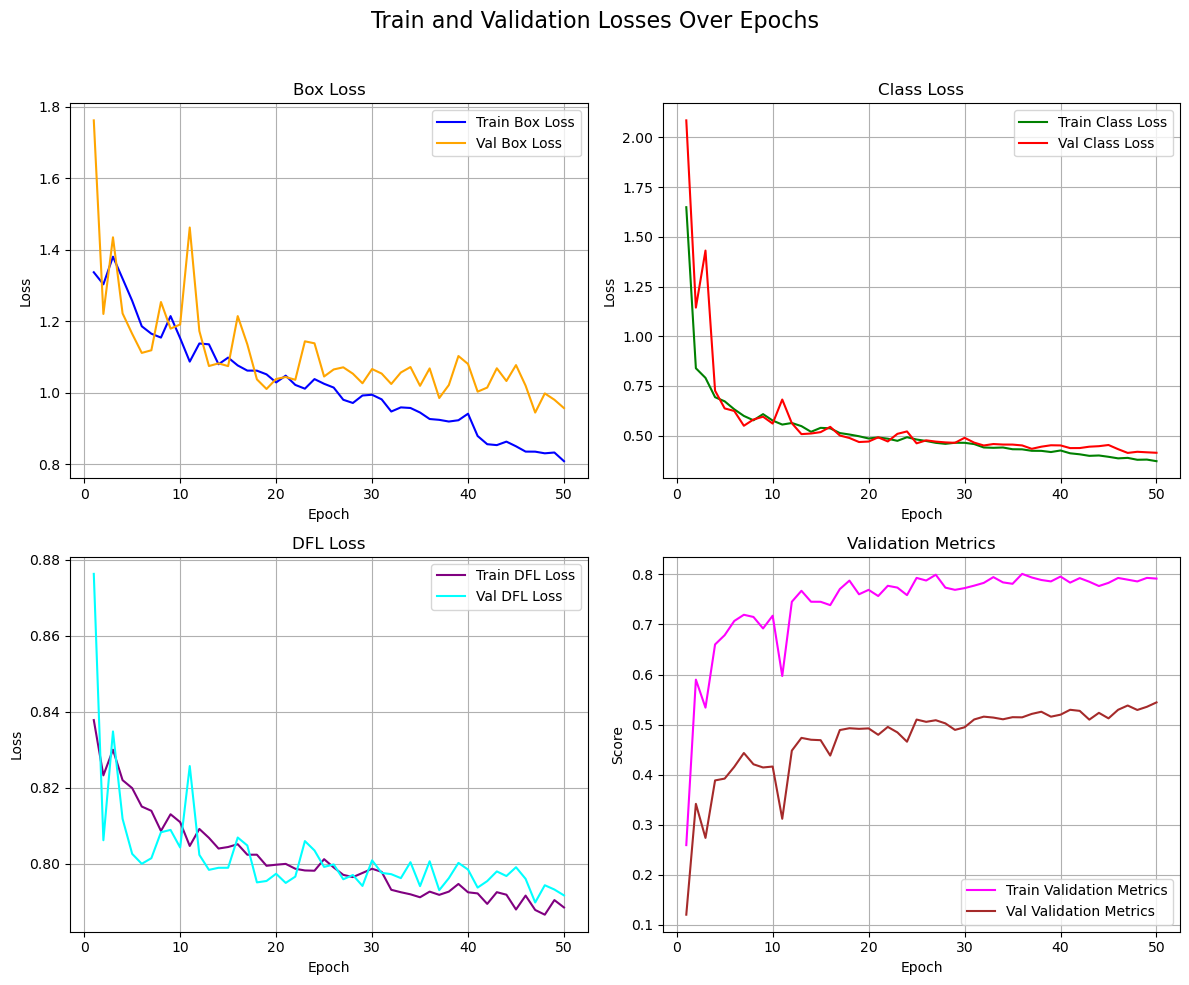

In [20]:
results_path = os.path.join(cwd, "yolo_football_analysis", "yolo5L_dataset_v0", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

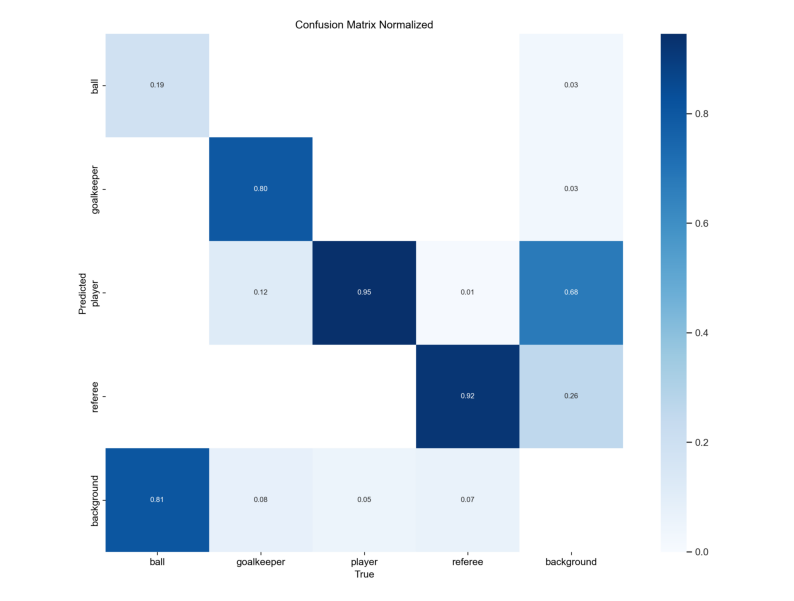

In [23]:
# load and show confusion matrix
matrix_path = os.path.join(cwd,"yolo_football_analysis" ,"yolo5L_dataset_v0", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## YOLO v9c


In [3]:
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov9c.pt")
model = model.cuda()
dataset_path = os.path.join(dataset_root_folder, "yolov9", "v0")

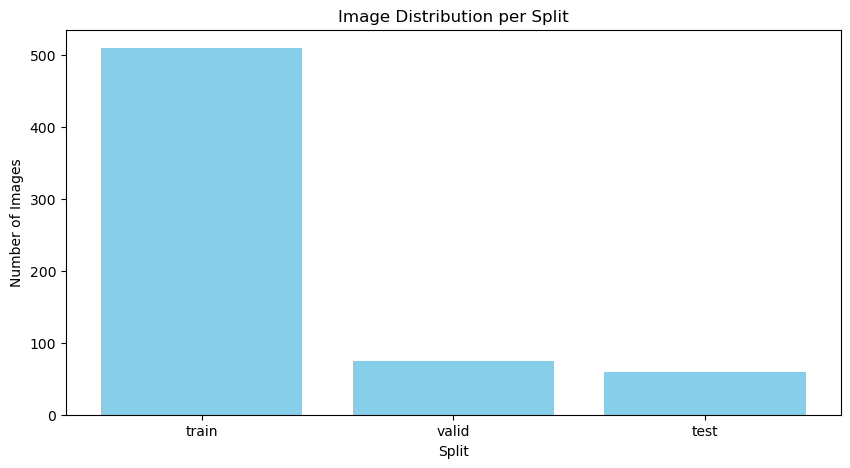

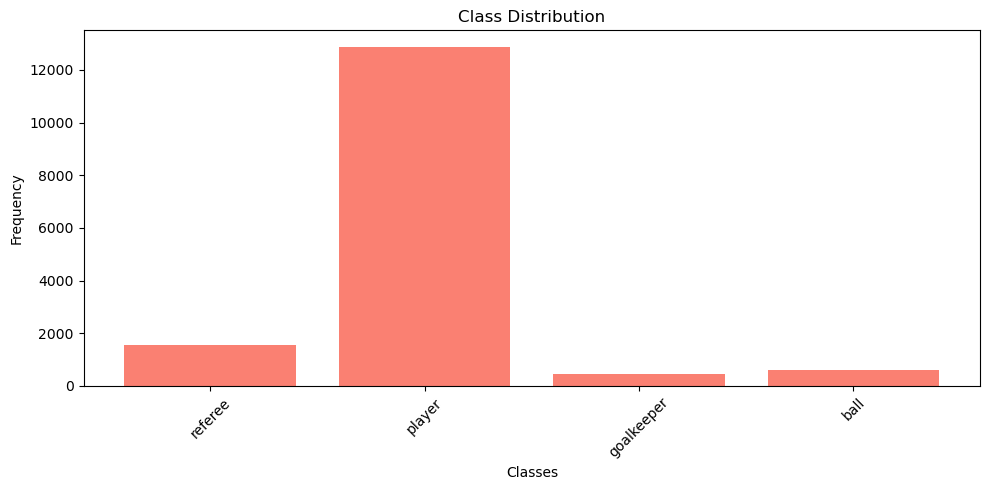

In [4]:
# plot dataset
plot_dataset(dataset_path)

In [5]:
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolo_football_analysis", name="yolo9c_dataset_v0")
wandb.finish()

New https://pypi.org/project/ultralytics/8.3.78 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov9c.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov9\v0\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolo_football_analysis, name=yolo9c_dataset_v0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

wandb: Currently logged in as: sianiemanuele (sianiemanuele_07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels...:   0%|          | 0/510 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels... 66 images, 0 backgrounds, 0 corrupt:  13%|█▎        | 66/510 [00:00<00:00, 623.84it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels... 133 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 133/510 [00:00<00:00, 618.04it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels... 207 images, 0 backgrounds, 0 corrupt:  41%|████      | 207/510 [00:00<00:00, 661.45it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels... 274 images, 0 backgrounds, 0 corrupt:  54%|█████▎    | 274/510 [00:00<00:00, 663.08it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels... 341 images, 0 backgrounds, 0 corrupt:  

train: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\train\labels.cache


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\valid\labels...:   0%|          | 0/75 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\valid\labels... 47 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 47/75 [00:00<00:00, 464.18it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\valid\labels... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 468.11it/s]


val: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov9\v0\valid\labels.cache
Plotting labels to yolo_football_analysis\yolo9c_dataset_v0\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_football_analysis\yolo9c_dataset_v0
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.3G      1.384      2.091     0.8414        613        640: 100%|██████████| 32/32 [08:21<00:00, 15.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.36s/it]


                   all         75       1796      0.416      0.439       0.41      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.2G      1.335     0.8251     0.8243        720        640: 100%|██████████| 32/32 [06:34<00:00, 12.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.67s/it]


                   all         75       1796      0.749      0.511        0.5      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.3G      1.552     0.8703     0.8495        532        640: 100%|██████████| 32/32 [07:13<00:00, 13.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


                   all         75       1796      0.562      0.356      0.295      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.1G      1.608     0.8335     0.8466        550        640: 100%|██████████| 32/32 [08:18<00:00, 15.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


                   all         75       1796      0.767      0.614      0.602      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.1G      1.318     0.6923      0.824        511        640: 100%|██████████| 32/32 [08:16<00:00, 15.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


                   all         75       1796       0.91      0.591      0.691       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.2G       1.26     0.6347     0.8184        520        640: 100%|██████████| 32/32 [08:22<00:00, 15.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.55s/it]


                   all         75       1796      0.819      0.666      0.692       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.2G      1.219     0.6046      0.818        586        640: 100%|██████████| 32/32 [07:23<00:00, 13.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


                   all         75       1796      0.803      0.671      0.719      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.2G      1.238     0.5931     0.8146        459        640: 100%|██████████| 32/32 [07:42<00:00, 14.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.65s/it]


                   all         75       1796      0.817      0.668      0.714      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.2G      1.236     0.5821     0.8146        543        640: 100%|██████████| 32/32 [07:53<00:00, 14.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


                   all         75       1796      0.867      0.666      0.721      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.2G       1.19     0.5664     0.8118        652        640: 100%|██████████| 32/32 [07:57<00:00, 14.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.82s/it]


                   all         75       1796      0.887      0.626      0.694      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.1G      1.173     0.5522     0.8144        671        640: 100%|██████████| 32/32 [07:22<00:00, 13.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.29s/it]


                   all         75       1796      0.831       0.63      0.711      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.2G      1.168     0.5575     0.8117        689        640: 100%|██████████| 32/32 [07:12<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


                   all         75       1796      0.757      0.578      0.621      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.2G      1.199     0.5542     0.8097        548        640: 100%|██████████| 32/32 [07:21<00:00, 13.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]


                   all         75       1796      0.889      0.683      0.746       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.2G      1.143     0.5364     0.8078        552        640: 100%|██████████| 32/32 [06:55<00:00, 12.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


                   all         75       1796      0.891      0.674      0.735      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.1G      1.103     0.5236     0.8045        471        640: 100%|██████████| 32/32 [07:15<00:00, 13.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.93s/it]


                   all         75       1796       0.86      0.696      0.735      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.2G      1.095      0.513     0.8061        702        640: 100%|██████████| 32/32 [07:09<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.99s/it]


                   all         75       1796      0.875       0.69       0.75      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.2G      1.035     0.4947      0.801        490        640: 100%|██████████| 32/32 [07:48<00:00, 14.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


                   all         75       1796       0.86      0.686      0.751      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.2G       1.06     0.5007     0.8031        751        640: 100%|██████████| 32/32 [07:17<00:00, 13.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


                   all         75       1796      0.692       0.66      0.696      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.1G      1.073     0.5174     0.8004        578        640: 100%|██████████| 32/32 [07:37<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.95s/it]


                   all         75       1796      0.893      0.676      0.707      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.1G      1.038     0.4899     0.8004        580        640: 100%|██████████| 32/32 [08:12<00:00, 15.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


                   all         75       1796      0.891      0.715      0.758      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.2G       1.07      0.497     0.8018        690        640: 100%|██████████| 32/32 [07:44<00:00, 14.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


                   all         75       1796      0.839      0.727      0.774      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.2G      1.046     0.4833        0.8        610        640: 100%|██████████| 32/32 [07:36<00:00, 14.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


                   all         75       1796      0.862      0.707      0.775      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.2G      1.018      0.469     0.7986        465        640: 100%|██████████| 32/32 [08:30<00:00, 15.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.34s/it]


                   all         75       1796      0.812      0.736      0.784      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.2G      1.008     0.4673      0.796        694        640: 100%|██████████| 32/32 [07:44<00:00, 14.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


                   all         75       1796      0.827      0.713      0.759      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.2G     0.9739      0.452     0.7977        530        640: 100%|██████████| 32/32 [07:52<00:00, 14.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


                   all         75       1796       0.84      0.743      0.779      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.1G      1.005     0.4593      0.798        447        640: 100%|██████████| 32/32 [07:46<00:00, 14.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


                   all         75       1796       0.86      0.725      0.777      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.2G      0.975      0.447     0.7962        503        640: 100%|██████████| 32/32 [08:00<00:00, 15.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


                   all         75       1796      0.867      0.731      0.785      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.2G      0.963     0.4395     0.7952        527        640: 100%|██████████| 32/32 [07:17<00:00, 13.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


                   all         75       1796      0.887      0.723      0.781       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        11G     0.9851     0.4485     0.7952        520        640: 100%|██████████| 32/32 [07:44<00:00, 14.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


                   all         75       1796       0.81      0.744      0.781      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.2G      1.003     0.4546     0.7983        494        640: 100%|██████████| 32/32 [07:34<00:00, 14.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.03s/it]


                   all         75       1796      0.816      0.743      0.791      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.2G      1.023     0.4538      0.799        545        640: 100%|██████████| 32/32 [07:11<00:00, 13.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.99s/it]


                   all         75       1796      0.818       0.74       0.78      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.2G      1.011     0.4472     0.7965        681        640: 100%|██████████| 32/32 [07:30<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


                   all         75       1796      0.859      0.703      0.769      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.2G      1.009     0.4409     0.7954        539        640: 100%|██████████| 32/32 [07:24<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


                   all         75       1796      0.867      0.744      0.785      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.2G     0.9911     0.4353     0.7936        589        640: 100%|██████████| 32/32 [07:24<00:00, 13.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.85s/it]


                   all         75       1796      0.922      0.719      0.768      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.2G     0.9834     0.4308     0.7932        490        640: 100%|██████████| 32/32 [07:43<00:00, 14.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


                   all         75       1796      0.845      0.729      0.783       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.1G     0.9402     0.4193     0.7935        587        640: 100%|██████████| 32/32 [07:57<00:00, 14.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


                   all         75       1796      0.866       0.74      0.799      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.2G     0.9306     0.4179     0.7932        523        640: 100%|██████████| 32/32 [08:17<00:00, 15.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


                   all         75       1796      0.916      0.761      0.803       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.1G     0.9078     0.4089     0.7921        606        640: 100%|██████████| 32/32 [07:54<00:00, 14.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


                   all         75       1796      0.853       0.75      0.803      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.2G     0.9208     0.4142     0.7942        502        640: 100%|██████████| 32/32 [07:56<00:00, 14.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


                   all         75       1796      0.886       0.73      0.792      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.2G     0.9239     0.4137     0.7922        640        640: 100%|██████████| 32/32 [07:57<00:00, 14.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


                   all         75       1796      0.902      0.755      0.802      0.519
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        11G     0.8718     0.4032     0.7911        325        640: 100%|██████████| 32/32 [07:37<00:00, 14.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]


                   all         75       1796      0.883      0.751      0.798      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        11G     0.8526     0.4024     0.7897        313        640: 100%|██████████| 32/32 [07:26<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


                   all         75       1796      0.846      0.744      0.797      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        11G     0.8623     0.4022     0.7938        329        640: 100%|██████████| 32/32 [07:19<00:00, 13.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


                   all         75       1796      0.882      0.715       0.78      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.2G     0.8681     0.4004     0.7928        318        640: 100%|██████████| 32/32 [07:09<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]


                   all         75       1796      0.882      0.731      0.791      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        11G       0.84     0.3867     0.7877        326        640: 100%|██████████| 32/32 [07:24<00:00, 13.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


                   all         75       1796      0.917      0.754      0.818      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50        11G     0.8249     0.3773     0.7906        327        640: 100%|██████████| 32/32 [07:20<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]


                   all         75       1796      0.908      0.749       0.81      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.2G     0.8393      0.382     0.7884        332        640: 100%|██████████| 32/32 [07:02<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.12s/it]


                   all         75       1796       0.91      0.732      0.803      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        11G     0.8287     0.3767     0.7863        332        640: 100%|██████████| 32/32 [07:52<00:00, 14.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


                   all         75       1796      0.919      0.745       0.81      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50        11G     0.8154     0.3711     0.7891        320        640: 100%|██████████| 32/32 [07:11<00:00, 13.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


                   all         75       1796      0.908      0.746      0.816      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        11G     0.8003     0.3629     0.7878        321        640: 100%|██████████| 32/32 [07:21<00:00, 13.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.12s/it]


                   all         75       1796      0.936      0.751      0.823      0.544

50 epochs completed in 6.605 hours.
Optimizer stripped from yolo_football_analysis\yolo9c_dataset_v0\weights\last.pt, 51.6MB
Optimizer stripped from yolo_football_analysis\yolo9c_dataset_v0\weights\best.pt, 51.6MB

Validating yolo_football_analysis\yolo9c_dataset_v0\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv9c summary (fused): 384 layers, 25,322,332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


                   all         75       1796      0.936      0.751      0.823      0.542
                  ball         73         73      0.952      0.269       0.41      0.132
            goalkeeper         50         50      0.897       0.82      0.912      0.626
                player         75       1493      0.973      0.958       0.99      0.755
               referee         75        180      0.923      0.956      0.979      0.656
Speed: 1.1ms preprocess, 28.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to yolo_football_analysis\yolo9c_dataset_v0


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
metrics/mAP50(B),▃▄▁▅▆▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇█▇▇▇▇█▇███████████
metrics/mAP50-95(B),▃▄▁▄▆▆▆▆▆▄▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█████▇▇█████
metrics/precision(B),▁▅▃▆█▆▆▇▇▆▇▇▇▇▅▇▇▇▇▇▇▇▆▆▆▇█▇▇█▇█▇▇▇█████
metrics/recall(B),▂▄▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇████▇▇██▇███▇██▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆▆██▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁


### Plots

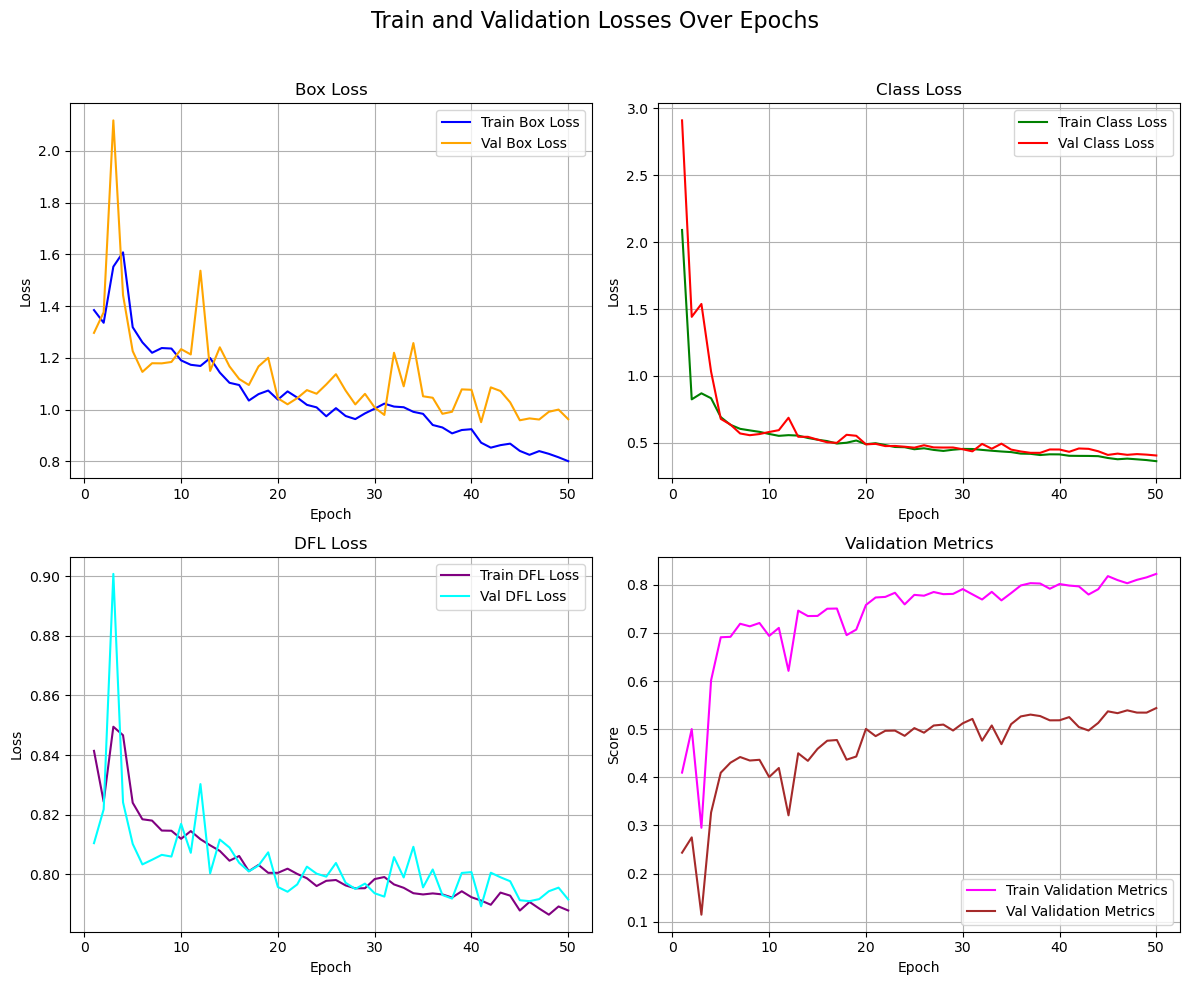

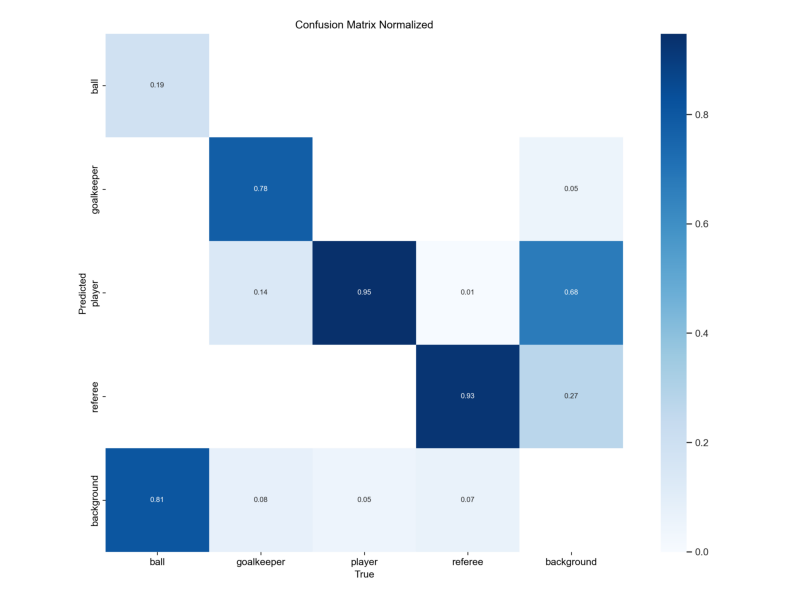

In [6]:
results_path = os.path.join(cwd, "yolo_football_analysis", "yolo9c_dataset_v0", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)
# load and show confusion matrix
matrix_path = os.path.join(cwd,"yolo_football_analysis" ,"yolo9c_dataset_v0", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



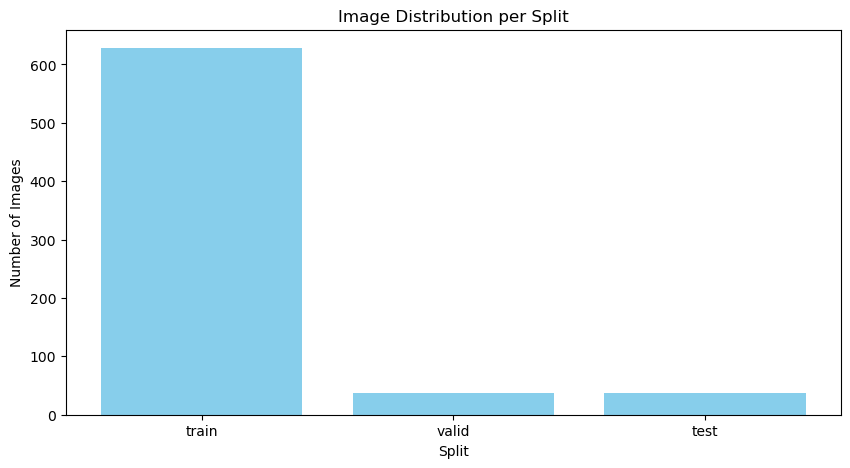

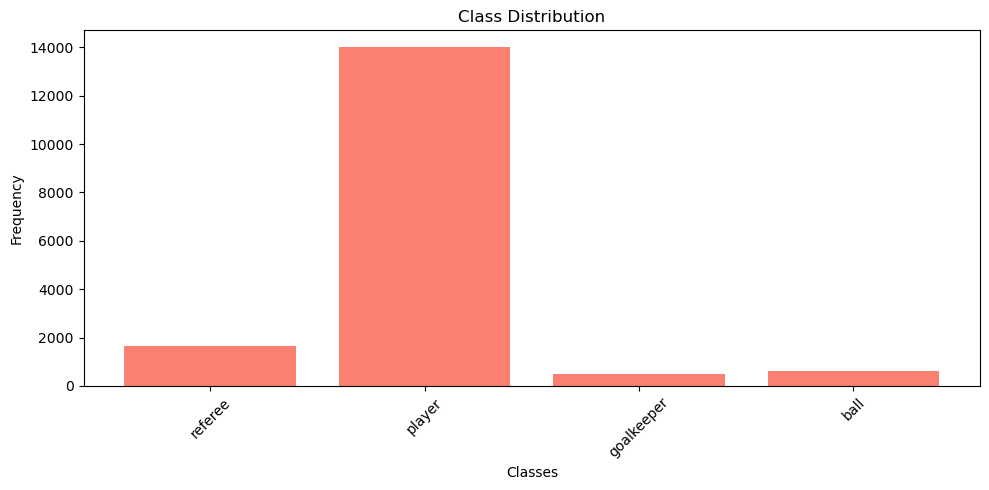

In [ ]:






#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov5l.pt")
model = model.cuda()
dataset_path = os.path.join(dataset_root_folder, "yolov5", "v2")
plot_dataset(dataset_path)

In [ ]:
# check if the model is on the GPU
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=100, imgsz=640, save=True, save_dir="yolov5")
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

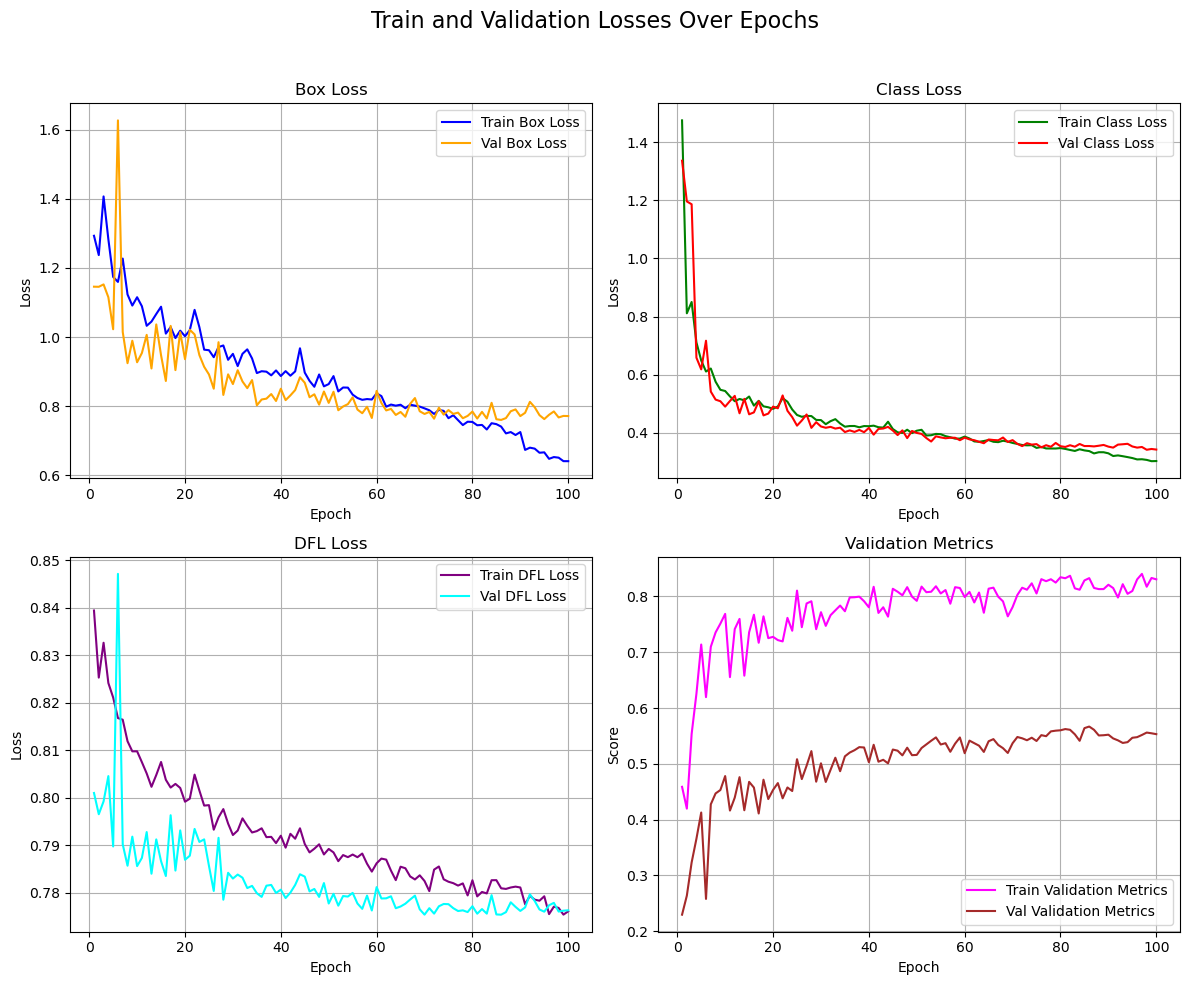

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
data
plot_losses(data)

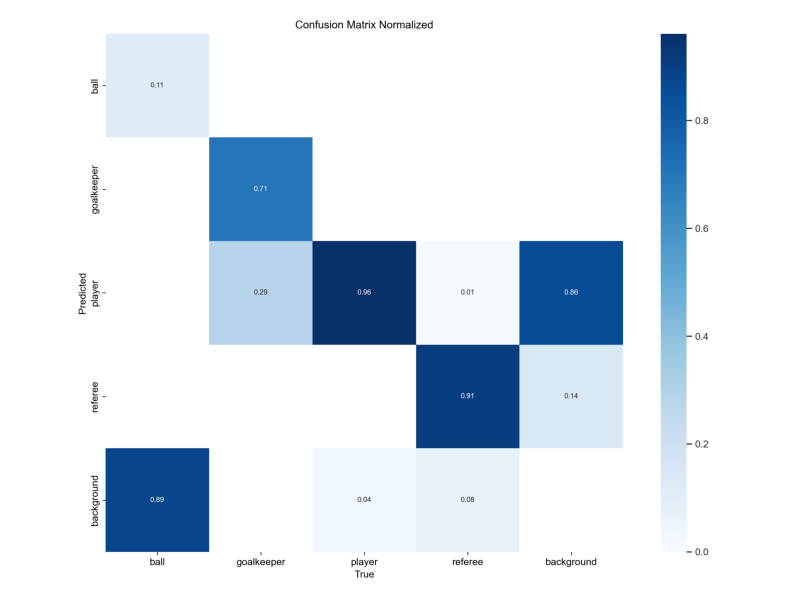

In [ ]:
matrix_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v3
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 188 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 3
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/4)

Train val test split:
* Train = 1215 images
* Val = 55 images
* Test = 40 images

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov5l.pt")
model = model.cuda()
dataset_path = os.path.join(dataset_root_folder, "yolov5", "v3")

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



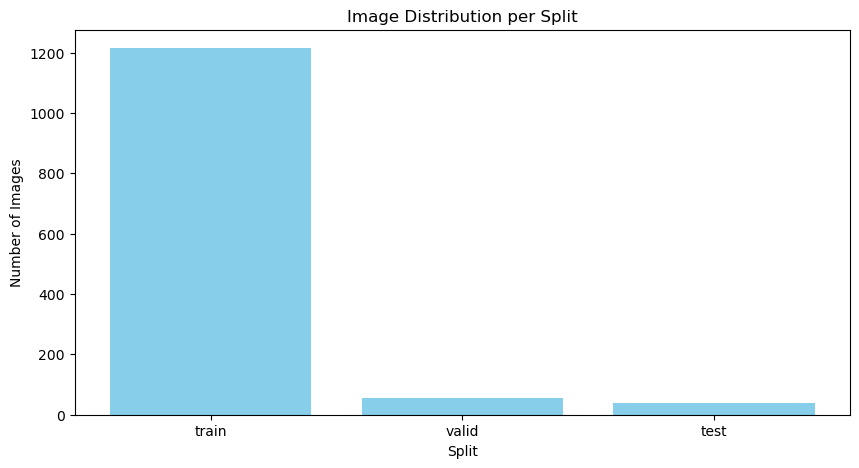

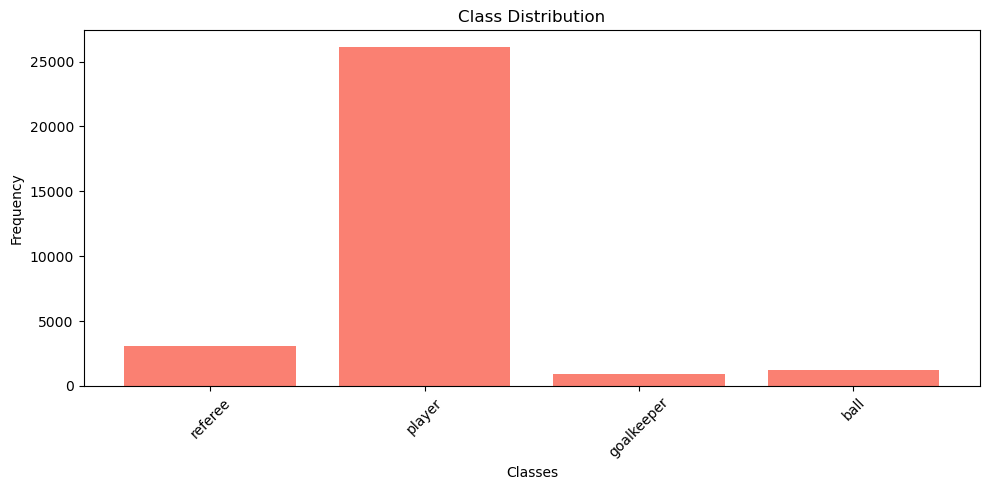

In [ ]:
# plot dataset
plot_dataset(dataset_path)

In [ ]:
# check if the model is on the GPU
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=100, imgsz=640, save=True, save_dir="yolov5")
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

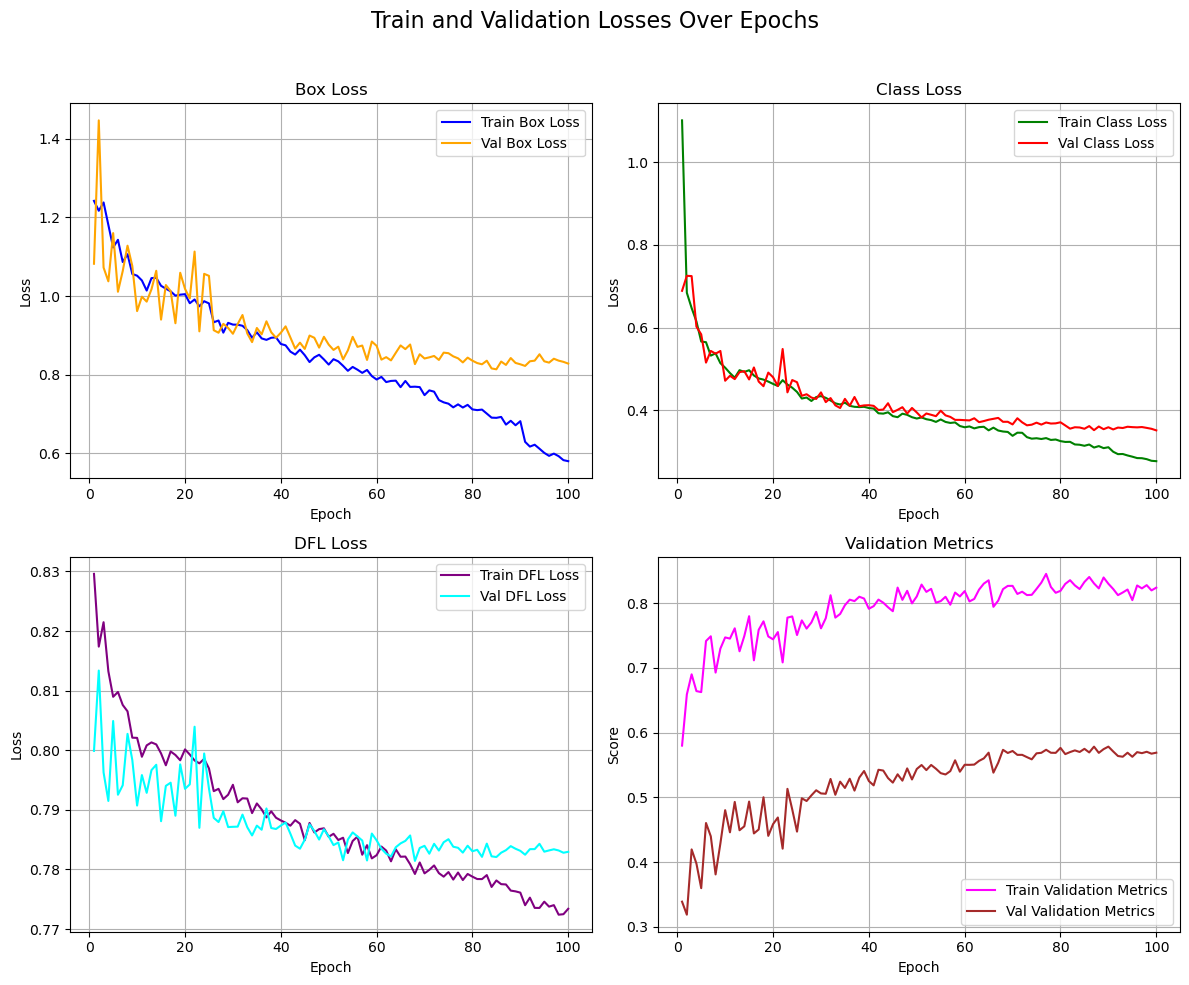

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v3", "results.csv")
data = pd.read_csv(results_path)
data
plot_losses(data)

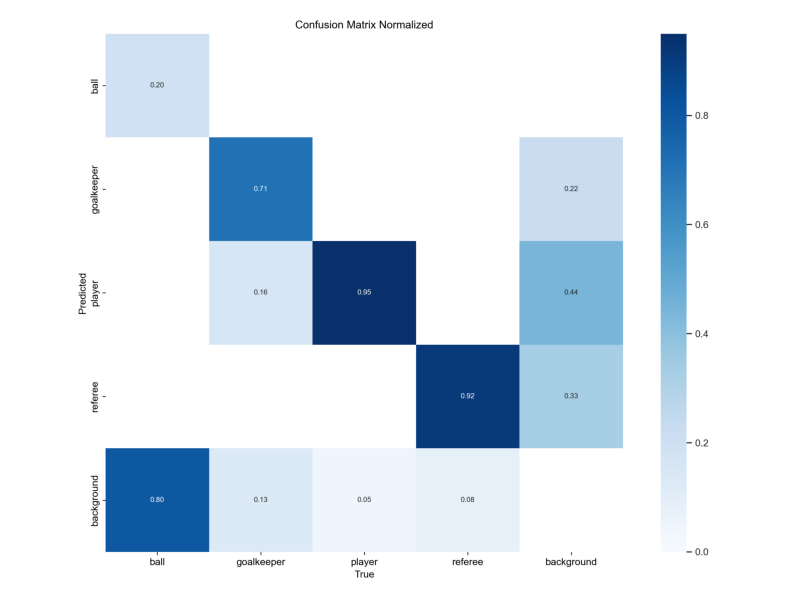

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v3", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

# YOLOv8

## v2
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 76 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 2
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/3)

Train val test split:
* Train = 628 images
* Val = 37 images
* Test = 37 images

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v2")
model.train(data=dataset_path, epochs=10, imgsz=640, save=True)
model.val(data=dataset_path, epochs=10, imgsz=640, save=True, project="AIxFootballAnalysis")

New https://pypi.org/project/ultralytics/8.3.56 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov9c.pt, data=C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov9\v1, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fal

RuntimeError: Dataset 'C://Users/siani/PycharmProjects/AIxFootballAnalysis/src/training/../../dataset/yolov9/v1' error  'C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov9\v1' does not exist

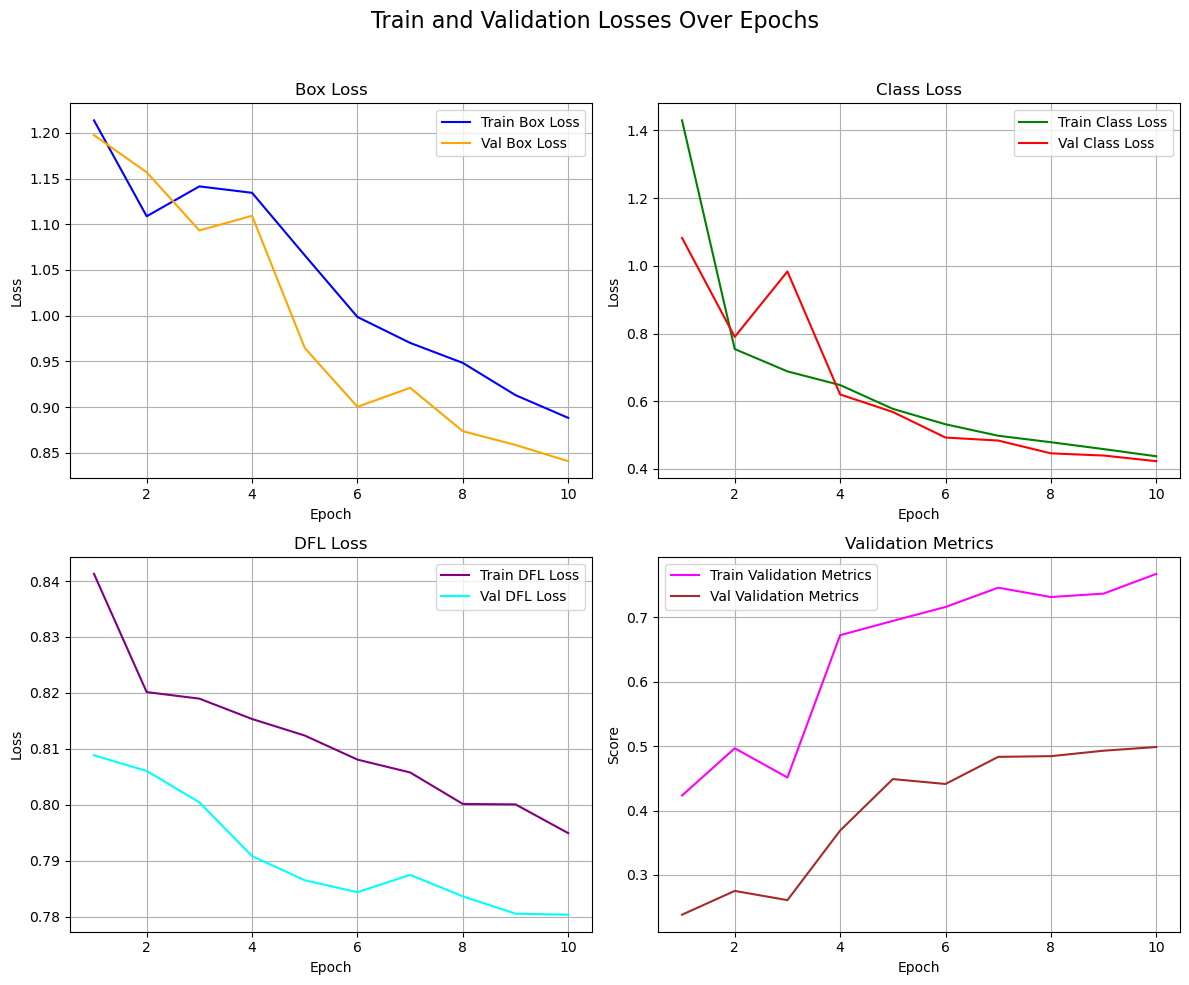

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo8m_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

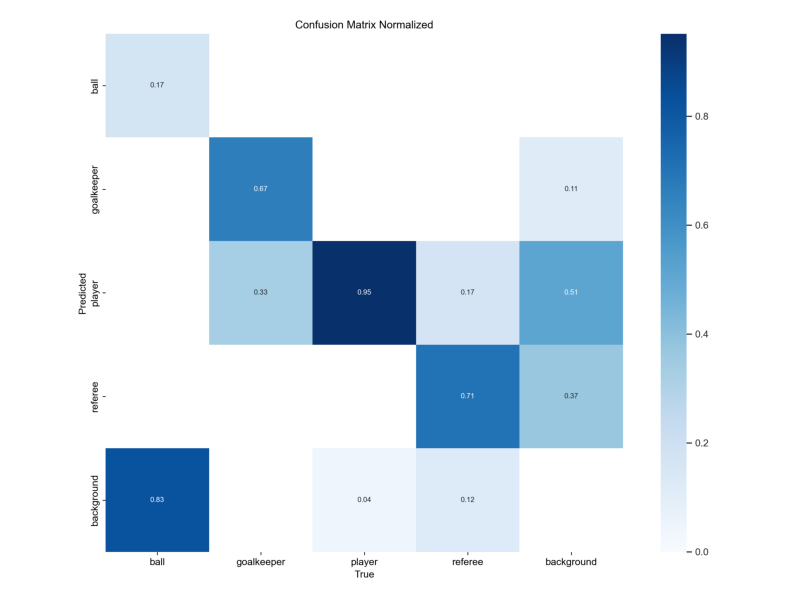

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo8m_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v2
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 76 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 2
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/3)

Train val test split:
* Train = 628 images
* Val = 37 images
* Test = 37 images


In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8l")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v2")
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=10, imgsz=640, save=True)
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=10, imgsz=640, save=True, project="AIxFootballAnalysis")

100%|██████████| 83.7M/83.7M [00:07<00:00, 12.5MB/s]


New https://pypi.org/project/ultralytics/8.3.57 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v2\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\train\labels.cache... 628 images, 0 backgrounds, 0 corrupt: 100%|██████████| 628/628 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\valid\labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train15
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.2G       1.24      1.823     0.8385         89        640: 100%|██████████| 40/40 [24:27<00:00, 36.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]

                   all         37        890      0.347      0.251       0.22      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      10.2G      1.143     0.8064     0.8235         91        640: 100%|██████████| 40/40 [21:59<00:00, 32.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.30s/it]

                   all         37        890      0.681       0.51       0.53      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      10.3G      1.147     0.6849     0.8221         93        640: 100%|██████████| 40/40 [21:38<00:00, 32.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.15s/it]

                   all         37        890      0.516      0.184      0.143     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      10.2G      1.133      0.662     0.8168         92        640: 100%|██████████| 40/40 [23:43<00:00, 35.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]

                   all         37        890      0.615      0.448      0.453      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.3G      1.077     0.5858      0.814         96        640: 100%|██████████| 40/40 [20:42<00:00, 31.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]

                   all         37        890      0.735      0.616      0.639       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      10.3G      1.034      0.542     0.8113         95        640: 100%|██████████| 40/40 [24:11<00:00, 36.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

                   all         37        890       0.75      0.656      0.688      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      10.3G     0.9754     0.4993     0.8059         95        640: 100%|██████████| 40/40 [20:37<00:00, 30.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.26s/it]

                   all         37        890      0.746      0.656      0.713      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.3G     0.9605     0.4873     0.8015         94        640: 100%|██████████| 40/40 [20:21<00:00, 30.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.69s/it]

                   all         37        890      0.788        0.7      0.731      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      10.2G     0.9147     0.4591     0.8015         87        640: 100%|██████████| 40/40 [21:56<00:00, 32.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.78s/it]

                   all         37        890      0.806      0.651      0.733      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      10.2G     0.8922     0.4406     0.7964         92        640: 100%|██████████| 40/40 [19:55<00:00, 29.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.73s/it]

                   all         37        890      0.812      0.698      0.739      0.497



10 epochs completed in 3.724 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 87.6MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


                   all         37        890      0.811      0.698      0.739        0.5
                  ball         35         35       0.82      0.171      0.246     0.0759
            goalkeeper         24         24      0.685      0.726      0.783      0.551
                player         37        742      0.932      0.962      0.984      0.761
               referee         37         89      0.808      0.933      0.941      0.612
Speed: 1.8ms preprocess, 136.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train15
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\valid\labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


                   all         37        890      0.813        0.7      0.741      0.504
                  ball         35         35      0.819      0.171      0.253     0.0731
            goalkeeper         24         24      0.685      0.725      0.783      0.549
                player         37        742      0.929      0.961      0.981      0.773
               referee         37         89      0.818      0.944      0.947      0.621
Speed: 2.1ms preprocess, 104.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to AIxFootballAnalysis\train15


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E65507BF40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

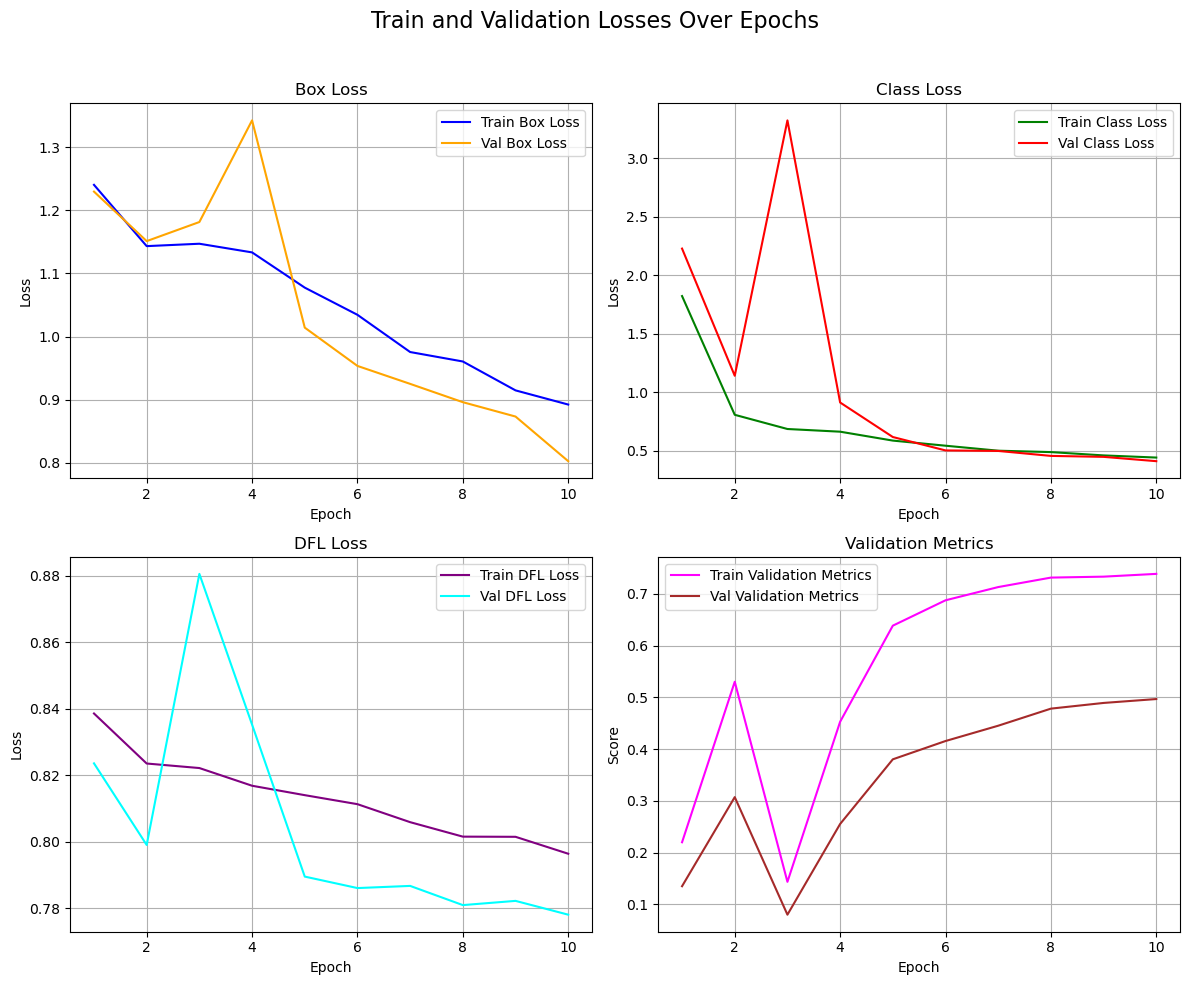

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo8l_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

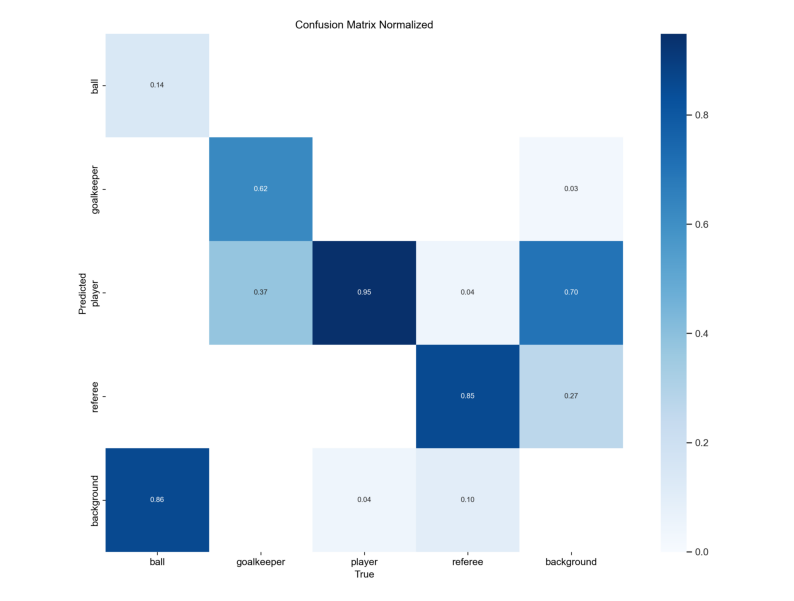

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo8l_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v3
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 188 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 3
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/4)

Train val test split:
* Train = 1215 images
* Val = 55 images
* Test = 40 images

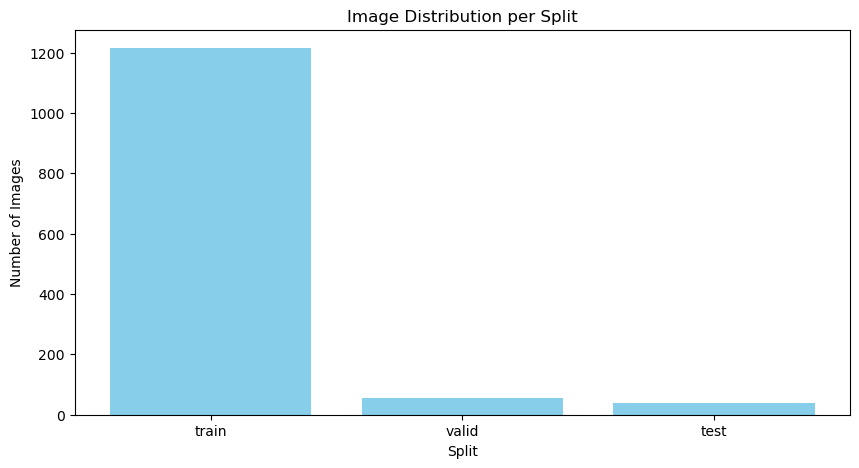

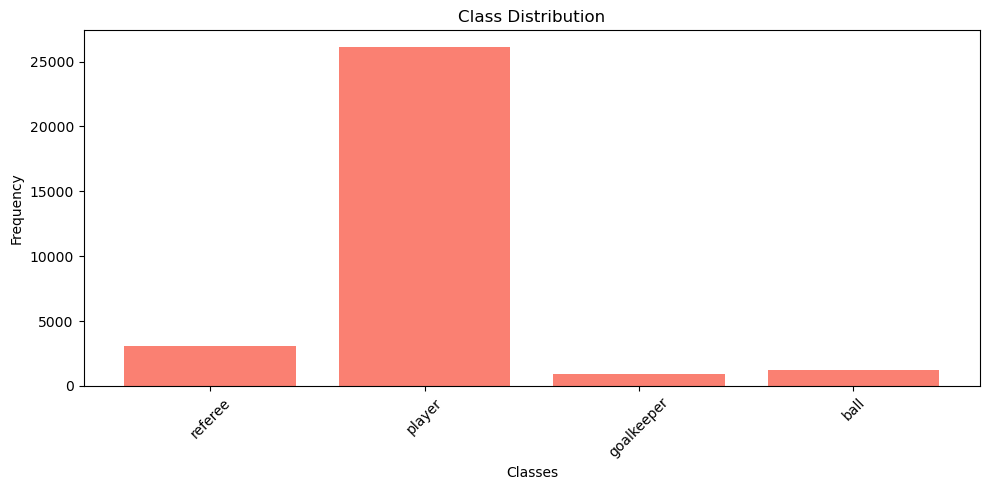

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8/v3, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\train\labels... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<00:00, 1584.32it/s]


train: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\train\labels.cache


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\valid\labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 985.99it/s]

val: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\valid\labels.cache


Plotting labels to yolov8\v3\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8\v3\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.32G      1.268      1.096     0.8327        434        640: 100%|██████████| 76/76 [06:24<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         55       1314      0.778      0.498      0.517      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.17G      1.206     0.6578     0.8142        485        640: 100%|██████████| 76/76 [07:52<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         55       1314      0.809      0.562      0.656      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.07G      1.258     0.6995     0.8166        685        640: 100%|██████████| 76/76 [07:26<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]

                   all         55       1314      0.689      0.586      0.568      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.12G      1.255     0.6801     0.8146        713        640: 100%|██████████| 76/76 [07:05<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

                   all         55       1314      0.711      0.612      0.667      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.12G      1.147     0.5635     0.8081        505        640: 100%|██████████| 76/76 [04:58<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]

                   all         55       1314      0.789      0.637      0.699      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.12G      1.155     0.5534     0.8079        550        640: 100%|██████████| 76/76 [09:01<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         55       1314      0.842      0.619      0.731      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.14G      1.093     0.5284     0.8042        459        640: 100%|██████████| 76/76 [07:15<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         55       1314      0.812      0.679      0.755      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.14G      1.087     0.5119     0.8021        690        640: 100%|██████████| 76/76 [08:01<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

                   all         55       1314      0.812      0.598      0.691      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.03G      1.081     0.5094     0.7998        584        640: 100%|██████████| 76/76 [06:50<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all         55       1314      0.862      0.695      0.749      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.13G      1.032     0.4862     0.7983        531        640: 100%|██████████| 76/76 [08:53<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         55       1314      0.786      0.705      0.741      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.12G      1.037      0.495     0.7966        726        640: 100%|██████████| 76/76 [06:03<00:00,  4.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.755      0.681      0.734      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.12G     0.9915     0.4701     0.7959        681        640: 100%|██████████| 76/76 [08:30<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         55       1314      0.811      0.737      0.777       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.11G      1.033     0.4811     0.7972        670        640: 100%|██████████| 76/76 [07:43<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         55       1314       0.91      0.663      0.745      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.14G      1.017     0.4744     0.7962        629        640: 100%|██████████| 76/76 [07:43<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]

                   all         55       1314      0.817      0.709      0.765      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.12G     0.9991     0.4675     0.7946        634        640: 100%|██████████| 76/76 [08:26<00:00,  6.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

                   all         55       1314      0.894      0.719       0.78      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.09G     0.9691     0.4501      0.791        500        640: 100%|██████████| 76/76 [05:07<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         55       1314      0.769      0.721      0.748      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.15G     0.9596     0.4515     0.7917        587        640: 100%|██████████| 76/76 [08:22<00:00,  6.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]

                   all         55       1314      0.834      0.729      0.777        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.11G     0.9716     0.4519      0.794        479        640: 100%|██████████| 76/76 [07:59<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         55       1314      0.864       0.71      0.775      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.13G     0.9866     0.4544     0.7936        467        640: 100%|██████████| 76/76 [08:24<00:00,  6.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         55       1314      0.816      0.707      0.761      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.09G     0.9468     0.4378      0.792        515        640: 100%|██████████| 76/76 [07:49<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

                   all         55       1314       0.82      0.728      0.775       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.11G     0.9297     0.4311     0.7917        523        640: 100%|██████████| 76/76 [07:09<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         55       1314       0.88       0.68      0.764      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.12G     0.9345     0.4356     0.7901        649        640: 100%|██████████| 76/76 [06:02<00:00,  4.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]

                   all         55       1314      0.818      0.727      0.804      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.11G     0.9207     0.4277     0.7901        684        640: 100%|██████████| 76/76 [06:27<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         55       1314       0.92       0.71      0.756      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.11G     0.9088     0.4251     0.7897        742        640: 100%|██████████| 76/76 [06:18<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

                   all         55       1314       0.84      0.726      0.787      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.15G     0.9185     0.4255     0.7886        639        640: 100%|██████████| 76/76 [06:47<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]

                   all         55       1314      0.845      0.738      0.794      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.09G     0.9005     0.4154     0.7867        562        640: 100%|██████████| 76/76 [07:08<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         55       1314      0.861      0.728      0.778      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.13G     0.8881     0.4104     0.7865        527        640: 100%|██████████| 76/76 [06:09<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         55       1314      0.819      0.726      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         7G     0.8905     0.4145     0.7861        572        640: 100%|██████████| 76/76 [05:49<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         55       1314      0.813      0.746      0.788      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.09G     0.8853     0.4095      0.786        580        640: 100%|██████████| 76/76 [05:12<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

                   all         55       1314      0.864       0.72      0.774      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.08G     0.8771     0.4062     0.7862        636        640: 100%|██████████| 76/76 [05:42<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         55       1314      0.815      0.699      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.05G     0.8783     0.4031     0.7844        670        640: 100%|██████████| 76/76 [05:06<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.866       0.71      0.775      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.07G     0.8857      0.399     0.7848        550        640: 100%|██████████| 76/76 [05:23<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         55       1314      0.832       0.74      0.792      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       7.1G     0.8371     0.3839     0.7836        528        640: 100%|██████████| 76/76 [05:28<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]

                   all         55       1314      0.874      0.759      0.808      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.13G     0.8466     0.3892     0.7822        631        640: 100%|██████████| 76/76 [08:03<00:00,  6.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all         55       1314      0.793      0.732      0.781      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.12G     0.8451      0.388     0.7831        743        640: 100%|██████████| 76/76 [07:12<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.828       0.73      0.792      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.06G     0.8271     0.3802     0.7815        541        640: 100%|██████████| 76/76 [04:18<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         55       1314      0.829      0.734      0.789      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.13G     0.8237     0.3816     0.7809        679        640: 100%|██████████| 76/76 [06:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.84s/it]

                   all         55       1314      0.896      0.752      0.811      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.08G     0.8138     0.3736     0.7813        664        640: 100%|██████████| 76/76 [04:24<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         55       1314      0.882      0.751      0.803      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.12G     0.8164     0.3761     0.7797        669        640: 100%|██████████| 76/76 [05:07<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

                   all         55       1314      0.859       0.75      0.788      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.04G     0.8043     0.3698     0.7794        561        640: 100%|██████████| 76/76 [06:45<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all         55       1314      0.804      0.744      0.785      0.517


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       7.2G     0.7638     0.3645     0.7796        356        640: 100%|██████████| 76/76 [04:42<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]

                   all         55       1314      0.856      0.758      0.802      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.21G     0.7413     0.3536     0.7797        353        640: 100%|██████████| 76/76 [05:01<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.88s/it]

                   all         55       1314      0.843      0.775      0.808      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.19G     0.7453     0.3521     0.7806        353        640: 100%|██████████| 76/76 [04:16<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         55       1314      0.865      0.741      0.806      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.19G     0.7395     0.3513      0.778        347        640: 100%|██████████| 76/76 [05:34<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.24s/it]

                   all         55       1314      0.863      0.735      0.798      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.2G     0.7125     0.3386      0.777        354        640: 100%|██████████| 76/76 [09:23<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         55       1314      0.894      0.758      0.835      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.17G     0.7041     0.3359     0.7768        344        640: 100%|██████████| 76/76 [07:28<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         55       1314      0.862       0.75      0.807      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.17G     0.6921     0.3303      0.776        338        640: 100%|██████████| 76/76 [07:05<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

                   all         55       1314      0.862      0.756      0.807      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.2G     0.6878     0.3272     0.7761        333        640: 100%|██████████| 76/76 [06:49<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]

                   all         55       1314      0.854      0.772       0.81      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.2G     0.6716     0.3203     0.7759        352        640: 100%|██████████| 76/76 [06:56<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all         55       1314      0.873      0.763      0.814       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.2G      0.664     0.3166     0.7765        353        640: 100%|██████████| 76/76 [03:57<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         55       1314      0.878      0.761      0.822      0.541



50 epochs completed in 5.636 hours.
Optimizer stripped from yolov8\v3\train\weights\last.pt, 52.0MB
Optimizer stripped from yolov8\v3\train\weights\best.pt, 52.0MB

Validating yolov8\v3\train\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.50s/it]


                   all         55       1314      0.894      0.758      0.835      0.557
                  ball         51         51      0.884        0.3      0.505      0.176
            goalkeeper         38         38      0.844      0.816      0.876      0.625
                player         55       1095      0.956      0.969      0.989      0.774
               referee         55        130      0.892      0.948      0.972      0.652
Speed: 0.2ms preprocess, 72.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to yolov8\v3\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018B4D994FD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3")
plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolov8/v3")

#model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

## v3 with copy paste augmentation


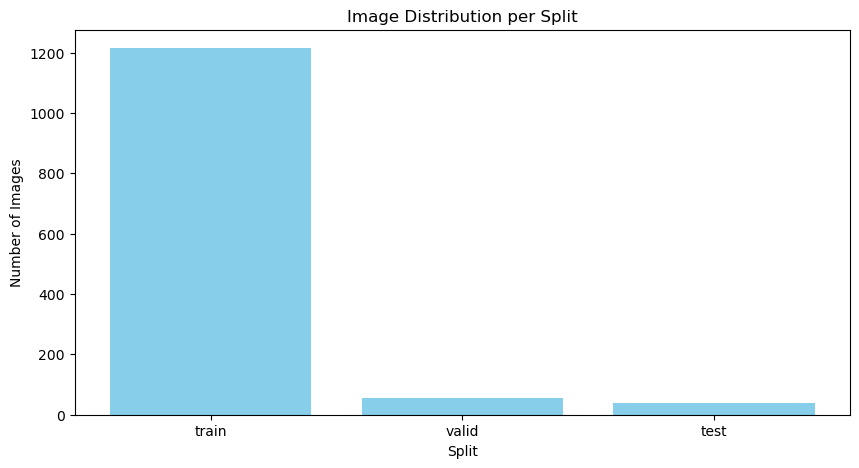

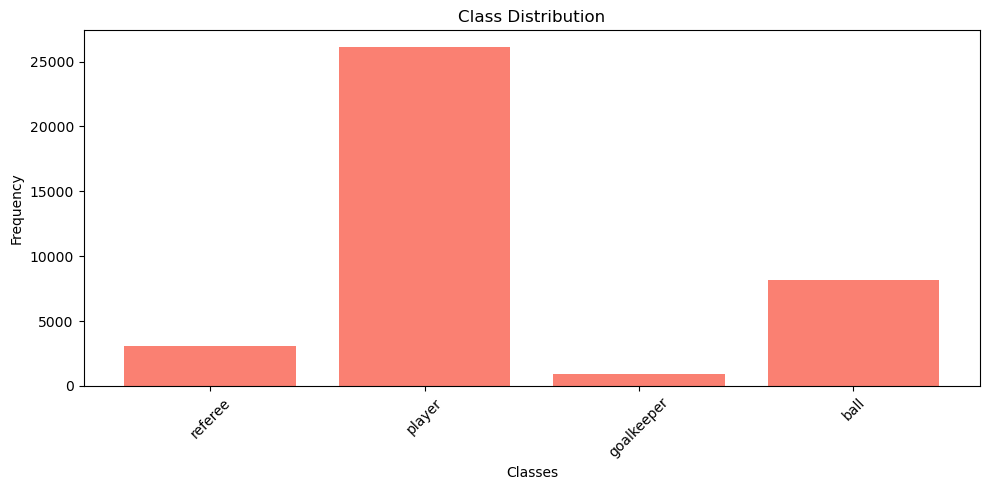

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3_copy_paste_aug\data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8_v3_copy_paste_aug, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

wandb: Currently logged in as: sianiemanuele (sianiemanuele_07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]


Plotting labels to yolov8_v3_copy_paste_aug\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8_v3_copy_paste_aug\train2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      7.64G       1.29       1.11     0.8331        590        640: 100%|██████████| 76/76 [05:24<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


                   all         55       1314      0.655      0.558      0.594      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      7.47G       1.17     0.6298     0.8078        582        640: 100%|██████████| 76/76 [04:51<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


                   all         55       1314      0.727      0.621      0.687      0.436

2 epochs completed in 0.178 hours.
Optimizer stripped from yolov8_v3_copy_paste_aug\train2\weights\last.pt, 52.0MB
Optimizer stripped from yolov8_v3_copy_paste_aug\train2\weights\best.pt, 52.0MB

Validating yolov8_v3_copy_paste_aug\train2\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


                   all         55       1314      0.728      0.622      0.686      0.435
                  ball         51         51      0.543      0.098      0.141     0.0463
            goalkeeper         38         38      0.861      0.653      0.813      0.534
                player         55       1095      0.916      0.943      0.975      0.674
               referee         55        130       0.59      0.792      0.816      0.487
Speed: 0.6ms preprocess, 26.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8_v3_copy_paste_aug\train2


lr/pg0,▁█
lr/pg1,▁█
lr/pg2,▁█
metrics/mAP50(B),▁█
metrics/mAP50-95(B),▁█
metrics/precision(B),▁█
metrics/recall(B),▁█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▁


In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
#add_wandb_callback(model, enable_model_checkpointing=True)
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3_copy_paste_aug")
plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=2, imgsz=640, save=True, project="yolov8_v3_copy_paste_aug")

wandb.finish()

#model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="yolov8/v3_copy_paste_aug")

In [ ]:
import torch
import torch.nn as nn
import os
from ultralytics import YOLO

class CustomComputeLoss:
    def __init__(self, model):
        self.model = model
        self.iou_weight = 1.0  # Standard IoU weight
        self.obj_weight = 1.0  # Objectness weight
        self.cls_weight = 1.0  # Classification weight
        self.small_object_boost = 2.0  # Boost weight for small objects

    def __call__(self, preds, targets):
        """ Compute custom loss while prioritizing small objects """
        iou_loss, obj_loss, cls_loss = self.model.loss(preds, targets)

        # Get bounding box areas (width * height)
        bbox_areas = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])

        # Identify small objects (area < 0.01 of image size)
        small_objects = bbox_areas < 0.01

        # Boost IoU loss for small objects
        iou_loss[small_objects] *= self.small_object_boost

        # Compute total loss
        total_loss = (self.iou_weight * iou_loss +
                      self.obj_weight * obj_loss +
                      self.cls_weight * cls_loss)
        return total_loss

# Initialize YOLO model
model = YOLO("yolov8m.pt").cuda()
add_wandb_callback(model, enable_model_checkpointing=True, enable_train_validation_logging=True)


# Replace the default loss function with our custom loss
model.loss = CustomComputeLoss(model)

# Train YOLO with the modified loss
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3_copy_paste_aug")
# plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolov8/v3_copy_paste_aug_CUSTOM_LOSS")

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3_copy_paste_aug\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8/v3_copy_paste_aug_CUSTOM_LOSS, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]


Plotting labels to yolov8\v3_copy_paste_aug_CUSTOM_LOSS\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8\v3_copy_paste_aug_CUSTOM_LOSS\train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.49G       1.29       1.11     0.8331        590        640: 100%|██████████| 76/76 [10:39<00:00,  8.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.60s/it]


                   all         55       1314      0.655      0.558      0.594      0.362
YOLOv8m summary (fused): 218 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:11<00:00,  2.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.36G      1.248      0.664     0.8135        582        640: 100%|██████████| 76/76 [05:59<00:00,  4.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


                   all         55       1314      0.718      0.622      0.673      0.365


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:11<00:00,  2.08it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.48G      1.226     0.6629     0.8149        804        640: 100%|██████████| 76/76 [07:32<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


                   all         55       1314      0.722      0.639      0.673      0.383


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.53G      1.247     0.6526     0.8116        764        640: 100%|██████████| 76/76 [09:39<00:00,  7.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


                   all         55       1314      0.728      0.628      0.669      0.395


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.09it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.55G      1.193     0.5885     0.8086        659        640: 100%|██████████| 76/76 [07:49<00:00,  6.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


                   all         55       1314      0.793      0.636      0.705      0.451


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.05G      1.133     0.5522     0.8019        640        640: 100%|██████████| 76/76 [08:35<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


                   all         55       1314      0.726      0.696      0.705      0.457


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.49G      1.143      0.547     0.8046        558        640: 100%|██████████| 76/76 [04:41<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


                   all         55       1314      0.825      0.687      0.721      0.417


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.11it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.56G      1.297     0.6129     0.8103        663        640:  55%|█████▌    | 42/76 [02:40<02:10,  3.83s/it]


KeyboardInterrupt: 